## OLA Business Case:

### Business Problem Statement:

- Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.
- As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.
- You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like:
   - Demographics (city, age, gender etc.)
   - Tenure information (joining date, Last Date)
   - Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

## Dataset Columns Information:

- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

## To Do: 
1. Perform basic univariate data analysis about each column of the data and find missing values/outliers
2. Aggregate data in order to remove multiple occurrences of same driver data
3. Perform data preprocessing - Duplicate value check and imputation, missing value check and imputation (using KNN Imputer), outlier treatment, class imbalance treatment, feature engineering (creating features for quarterly rating increase and monthly income increase), target variable creation
4. Find which features contribute the most towards driver churn using EDA (bi-variate analysis) and Hypothesis testing
5. Check correlation among independent variables and how they interact with each other
6. Use Bagging and Boosting models, explain the results, try with Hyperparameter tuning
7. Do model evaluation (Classification Report/ROC-AUC/Precision-Recall)
8. Provide actionable Insights & Recommendations


## Importing required Libraries and Dataset:

In [3]:
import calendar
import joblib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm

from sklearn.metrics import (
    classification_report, roc_auc_score,
    roc_curve, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
!python -m wget https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv


Saved under ola_driver_scaler.csv


In [14]:
df = pd.read_csv("ola_driver_scaler.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df_original = df.copy()

In [15]:
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [16]:
df.tail()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
19099,08/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,740280,3
19100,09/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,448370,3
19101,10/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,0,2
19102,11/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,200420,2
19103,12/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,411480,2


## Basic Statistical Summary of Dataset:

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [18]:
df.describe(include="all")

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104,19104.000000,19043.000000,19052.000000,19104,19104.000000,19104.000000,19104,1616,19104.000000,19104.000000,1.910400e+04,19104.000000
unique,24,NaN,NaN,NaN,29,NaN,NaN,869,493,NaN,NaN,NaN,NaN
top,01/01/19,NaN,NaN,NaN,C20,NaN,NaN,23/07/15,29/07/20,NaN,NaN,NaN,NaN
freq,1022,NaN,NaN,NaN,1008,NaN,NaN,192,70,NaN,NaN,NaN,NaN
mean,NaN,1415.591133,34.668435,0.418749,NaN,1.021671,65652.025126,NaN,NaN,1.690536,2.252670,5.716621e+05,2.008899
std,NaN,810.705321,6.257912,0.493367,NaN,0.800167,30914.515344,NaN,NaN,0.836984,1.026512,1.128312e+06,1.009832
min,NaN,1.000000,21.000000,0.000000,NaN,0.000000,10747.000000,NaN,NaN,1.000000,1.000000,-6.000000e+06,1.000000
25%,NaN,710.000000,30.000000,0.000000,NaN,0.000000,42383.000000,NaN,NaN,1.000000,1.000000,0.000000e+00,1.000000
50%,NaN,1417.000000,34.000000,0.000000,NaN,1.000000,60087.000000,NaN,NaN,1.000000,2.000000,2.500000e+05,2.000000
75%,NaN,2137.000000,39.000000,1.000000,NaN,2.000000,83969.000000,NaN,NaN,2.000000,3.000000,6.997000e+05,3.000000


In [19]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [20]:
df.shape

(19104, 13)

### Checking datatypes of columns in Dataset:

In [22]:
df.dtypes

MMM-YY                   object
Driver_ID                 int64
Age                     float64
Gender                  float64
City                     object
Education_Level           int64
Income                    int64
Dateofjoining            object
LastWorkingDate          object
Joining Designation       int64
Grade                     int64
Total Business Value      int64
Quarterly Rating          int64
dtype: object

## Data Preprocessing:
#### Updating the names of columns in Dataset:

In [23]:
df = df.rename(columns={"Dateofjoining": "Date_Of_Joining",
                        "LastWorkingDate": "Last_Working_Date",
                        "Joining Designation": "Joining_Designation",
                        "Total Business Value": "Total_Business_Value",
                        "Quarterly Rating": "Quarterly_Rating"
                       })

In [24]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Date_Of_Joining', 'Last_Working_Date', 'Joining_Designation',
       'Grade', 'Total_Business_Value', 'Quarterly_Rating'],
      dtype='object')

## Data Preprocessing:
#### Updating the datatypes of specific columns in Dataset:

In [25]:
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'], format="%m/%d/%y")
df['Date_Of_Joining'] = pd.to_datetime(df['Date_Of_Joining'], format="%d/%m/%y")
df['Last_Working_Date'] = pd.to_datetime(df['Last_Working_Date'], format="%d/%m/%y")

### Unique Values in Columns:

In [26]:
df.nunique()

MMM-YY                     24
Driver_ID                2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Income                   2383
Date_Of_Joining           869
Last_Working_Date         493
Joining_Designation         5
Grade                       5
Total_Business_Value    10181
Quarterly_Rating            4
dtype: int64

## Data Preprocessing:
#### Duplicate Value Check:

In [28]:
def find_duplicate_rows(df):
    duplicate_row_indices = df[df.duplicated(keep=False)].index.tolist()
    if len(duplicate_row_indices) > 0:
        return duplicate_row_indices
    else:
        return "No duplicate rows found in the DataFrame."

In [30]:
find_duplicate_rows(df)

'No duplicate rows found in the DataFrame.'

In [29]:
def find_duplicate_columns(df):
    duplicate_columns = set()
    for i in range(df.shape[1]):
        col = df.iloc[:,i]
        for j in range(i+1, df.shape[1]):
            if col.equals(df.iloc[:,j]):
                duplicate_columns.add(df.columns[j])
    if len(duplicate_columns) > 0:
        return list(duplicate_columns)
    else:
        return "No duplicate columns found in the DataFrame."

In [31]:
find_duplicate_columns(df)

'No duplicate columns found in the DataFrame.'

## Data Preprocessing:
#### Missing Value Check and Imputation:

In [32]:
def find_missing_value_percentage(df):

    missing_df = df.isna().sum()
    missing_df_non_zero = missing_df[missing_df!=0]
    missing_df_non_zero.sort_values(ascending=False, inplace=True)
    missing_df_non_zero_perc = (missing_df_non_zero/df.shape[0]).round(4)*100
    missing_df_non_zero_perc = [
        str(round(x, 2)) + ' %' for x in list(missing_df_non_zero_perc.values)
    ]
    missing_values_final_df = pd.DataFrame({
        'Feature name' : list(missing_df_non_zero.index),
        'Missing value %' : missing_df_non_zero_perc
        }
    )
    print(missing_values_final_df)

In [33]:
find_missing_value_percentage(df)

        Feature name Missing value %
0  Last_Working_Date         91.54 %
1                Age          0.32 %
2             Gender          0.27 %


#### There is a very high percentage of missing values in LastworkingDate but that's okay because that's not a feature used in model training, it'll be actually used to create target variable (is_churned)

## Data Preprocessing:
#### Initial Cleaning, Preprocessing and Aggregation before EDA:

In [35]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Date_Of_Joining', 'Last_Working_Date', 'Joining_Designation',
       'Grade', 'Total_Business_Value', 'Quarterly_Rating'],
      dtype='object')

In [34]:
df.sort_values(by=['Driver_ID', 'MMM-YY'], inplace=True)

In [36]:
dfg = df.groupby('Driver_ID').agg({
    'MMM-YY' : 'count',
    'Age' : 'mean',
    'Gender' : 'mean',
    'City' : 'first',
    'Education_Level' : 'first',
    'Income' : 'unique',
    'Date_Of_Joining' : 'first',
    'Last_Working_Date': 'last',
    'Joining_Designation': 'first',
    'Grade': 'unique',
    'Total_Business_Value': 'unique',
    'Quarterly_Rating': 'unique'
}).reset_index()

In [45]:
def create_increase_flag(ip_array):
    if len(ip_array)==1:
        return 0
    diff_array = ip_array[1:] - ip_array[:-1]
    diff_array[diff_array == 0] = 0
    diff_array[diff_array > 0] = 1
    diff_array[diff_array < 0] = -1
    return diff_array.mean()


def create_last_tenure_diff(input_array):
    if len(input_array)==1:
        return 0
    return np.sign(input_array[-1] - input_array[-2])


def is_promoted(row):
    diff = row['avg_grade'] - row['Joining_Designation']
    if math.isclose(diff, 0):
        return 0
    elif diff > 0:
        return 1
    return -1

In [38]:
dfg.rename(columns={'MMM-YY' : 'num_months'}, inplace=True)
dfg['DOJ_Year'] = dfg['Date_Of_Joining'].dt.year
dfg['DOJ_Month'] = dfg['Date_Of_Joining'].dt.month_name()
dfg['Gender'] = dfg['Gender'].map({0.0 : 'Male', 1.0 : 'Female'})
dfg['Age'] = dfg['Age'].astype('int')

In [39]:
dfg['avg_income'] = dfg['Income'].apply(np.mean)
dfg['income_increase_flag'] = dfg['Income'].apply(create_increase_flag)
dfg['income_last_tenure_diff'] = dfg['Income'].apply(create_last_tenure_diff).astype('int')

In [40]:
dfg['avg_grade'] = dfg['Grade'].apply(np.mean)
dfg['grade_increase_flag'] = dfg['Grade'].apply(create_increase_flag)
dfg['grade_last_tenure_diff'] = dfg['Grade'].apply(create_last_tenure_diff)

In [41]:
dfg['avg_total_business_value'] = dfg['Total_Business_Value'].apply(np.mean)
dfg['total_business_value_increase_flag'] = dfg['Total_Business_Value'].apply(create_increase_flag)
dfg['total_business_value_last_tenure_diff'] = dfg['Total_Business_Value'].apply(create_last_tenure_diff).astype('int')

In [42]:
dfg['avg_quarterly_rating'] = dfg['Quarterly_Rating'].apply(np.mean)
dfg['quarterly_rating_increase_flag'] = dfg['Quarterly_Rating'].apply(create_increase_flag)
dfg['quarterly_rating_last_tenure_diff'] = dfg['Quarterly_Rating'].apply(create_last_tenure_diff).astype('int')

In [46]:
dfg['is_promoted'] = dfg.apply(is_promoted, axis=1)
dfg['churned'] = [0]*dfg.shape[0]
dfg.loc[~dfg.Last_Working_Date.isnull(), 'churned'] = 1

In [48]:
dfg.drop(
    columns=[
        'Income', 'Grade', 'Total_Business_Value',
        'Quarterly_Rating', 'Last_Working_Date',
        'Driver_ID', 'Date_Of_Joining'
    ],
    inplace=True
)

In [51]:
dfg['index'] = dfg.index

In [52]:
dfg.columns

Index(['num_months', 'Age', 'Gender', 'City', 'Education_Level',
       'Joining_Designation', 'DOJ_Year', 'DOJ_Month', 'avg_income',
       'income_increase_flag', 'income_last_tenure_diff', 'avg_grade',
       'grade_increase_flag', 'grade_last_tenure_diff',
       'avg_total_business_value', 'total_business_value_increase_flag',
       'total_business_value_last_tenure_diff', 'avg_quarterly_rating',
       'quarterly_rating_increase_flag', 'quarterly_rating_last_tenure_diff',
       'is_promoted', 'churned', 'index'],
      dtype='object')

In [53]:
dfg.head()

,num_months,Age,Gender,City,Education_Level,Joining_Designation,DOJ_Year,DOJ_Month,avg_income,income_increase_flag,income_last_tenure_diff,avg_grade,grade_increase_flag,grade_last_tenure_diff,avg_total_business_value,total_business_value_increase_flag,total_business_value_last_tenure_diff,avg_quarterly_rating,quarterly_rating_increase_flag,quarterly_rating_last_tenure_diff,is_promoted,churned,index
0,3,28,Male,C23,2,1,2018,December,57387.0,0.0,0,1.0,0.0,0,571860.0,0.0,1,2.0,0.0,0,0,1,0
1,2,31,Male,C7,2,2,2020,June,67016.0,0.0,0,2.0,0.0,0,0.0,0.0,0,1.0,0.0,0,0,0,1
2,5,43,Male,C13,2,2,2019,July,65603.0,0.0,0,2.0,0.0,0,175000.0,1.0,1,1.0,0.0,0,0,1,2
3,3,29,Male,C9,0,1,2019,September,46368.0,0.0,0,1.0,0.0,0,60180.0,1.0,1,1.0,0.0,0,0,1,3
4,5,31,Female,C11,1,3,2020,July,78728.0,0.0,0,3.0,0.0,0,632500.0,1.0,1,1.5,1.0,1,0,0,4


In [54]:
dfg.tail()

,num_months,Age,Gender,City,Education_Level,Joining_Designation,DOJ_Year,DOJ_Month,avg_income,income_increase_flag,income_last_tenure_diff,avg_grade,grade_increase_flag,grade_last_tenure_diff,avg_total_business_value,total_business_value_increase_flag,total_business_value_last_tenure_diff,avg_quarterly_rating,quarterly_rating_increase_flag,quarterly_rating_last_tenure_diff,is_promoted,churned,index
2376,24,33,Male,C24,0,2,2015,October,82815.0,0.0,0,3.0,0.0,0,945600.869565,0.090909,-1,2.666667,0.0,1,1,0,2376
2377,3,34,Female,C9,0,1,2020,August,12105.0,0.0,0,1.0,0.0,0,0.000000,0.000000,0,1.000000,0.0,0,0,1,2377
2378,9,44,Male,C19,0,2,2018,July,35370.0,0.0,0,2.0,0.0,0,402155.714286,0.000000,1,1.500000,-1.0,-1,0,1,2378
2379,6,28,Female,C20,2,1,2018,July,69498.0,0.0,0,1.0,0.0,0,244457.500000,-0.333333,-1,1.500000,-1.0,-1,0,1,2379
2380,7,29,Male,C27,2,2,2020,August,70254.0,0.0,0,2.0,0.0,0,383040.000000,0.200000,1,2.000000,0.0,-1,0,0,2380


In [56]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   num_months                             2381 non-null   int64  
 1   Age                                    2381 non-null   int32  
 2   Gender                                 2381 non-null   object 
 3   City                                   2381 non-null   object 
 4   Education_Level                        2381 non-null   int64  
 5   Joining_Designation                    2381 non-null   int64  
 6   DOJ_Year                               2381 non-null   int64  
 7   DOJ_Month                              2381 non-null   object 
 8   avg_income                             2381 non-null   float64
 9   income_increase_flag                   2381 non-null   float64
 10  income_last_tenure_diff                2381 non-null   int32  
 11  avg_

In [57]:
dfg.shape

(2381, 23)

#### After aggregation, there are only 2500 rows, hence the dataset size is quite less

In [58]:
find_missing_value_percentage(dfg)

Empty DataFrame
Columns: [Feature name, Missing value %]
Index: []


#### There are no missing values in the new dataset

## Data Preprocessing:
#### KNN Imputation:

#### Note: Missing value imputation technique like KNNImputation is not needed because the aggregation automatically takes care of missing values as well as create new features.

In [59]:
dfg.describe()

,num_months,Age,Education_Level,Joining_Designation,DOJ_Year,avg_income,income_increase_flag,income_last_tenure_diff,avg_grade,grade_increase_flag,grade_last_tenure_diff,avg_total_business_value,total_business_value_increase_flag,total_business_value_last_tenure_diff,avg_quarterly_rating,quarterly_rating_increase_flag,quarterly_rating_last_tenure_diff,is_promoted,churned,index
count,2381.00000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,8.02352,33.149937,1.00756,1.820244,2018.536329,59272.610248,0.018480,0.018480,2.087778,0.018480,0.018480,3.745311e+05,0.122662,-0.019740,1.536679,0.036539,-0.005880,0.171357,0.678706,1190.000000
std,6.78359,5.868427,0.81629,0.841433,1.609597,28325.327154,0.134706,0.134706,0.934101,0.134706,0.134706,4.994292e+05,0.439303,0.836176,0.672356,0.596848,0.681051,0.376899,0.467071,687.479818
min,1.00000,21.000000,0.00000,1.000000,2013.000000,10747.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-2.771060e+05,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,3.00000,29.000000,0.00000,1.000000,2018.000000,39104.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,595.000000
50%,5.00000,33.000000,1.00000,2.000000,2019.000000,55285.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.239375e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1190.000000
75%,10.00000,37.000000,2.00000,2.000000,2020.000000,75835.000000,0.000000,0.000000,3.000000,0.000000,0.000000,5.325633e+05,0.250000,1.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1785.000000
max,24.00000,58.000000,2.00000,5.000000,2020.000000,188418.000000,1.000000,1.000000,5.000000,1.000000,1.000000,4.333230e+06,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,2380.000000


In [60]:
df = dfg.copy()

## Exploratory Data Analysis (EDA):

### Defining important functions for performing EDA:

In [61]:
def display_normalized_value_counts(data, col):
    print(data[col].value_counts(normalize=True).round(4)*100)

In [62]:
def display_cumulative_value_counts(data, col):
    print((data[col].value_counts(normalize=True).round(4)*100).cumsum())

In [63]:
def display_countplot(data, col, order=False, order_list=None, rot=False):
    if order:
        order = order_list if order_list else sorted(data[col].astype('int').unique().tolist())
        sns.countplot(data=data, x=col, order=order)
    else:
        sns.countplot(data=data, x=col)
    if rot:
        plt.xticks(rotation=90)
    plt.show()

In [162]:
def display_countplot_with_hue(data, col_x, col_hue, order_col=None, rot=False):
    if order_col:
        sns.countplot(data=data, x=col_x, hue=col_hue, order=order_col)
    else:
        sns.countplot(data=data, x=col_x, hue=col_hue)
    if rot:
        plt.xticks(rotation=60)
        plt.show()

In [65]:
def display_countplot_top_k_categories(data, col, k, include_na=False, rot=False):
    if not include_na:
        data=data.loc[((~data[col].isna()) & (data[col]!='NA'))]
    top_k_categories = data[col].value_counts()[:k].index.tolist()
    sns.countplot(data=data.loc[data[col].isin(top_k_categories)], x=col, order=top_k_categories)
    if rot:
        plt.xticks(rotation=45)
    plt.show()

In [66]:
def display_kde_plot(data, col):
    sns.kdeplot(data=data, x=col)
    plt.grid()
    plt.show()

In [67]:
def display_kde_plot_with_hue(data, col_x, col_hue, hue_order=None):
    sns.kdeplot(data=data, x=col_x, hue=col_hue, hue_order=hue_order)
    plt.grid()
    plt.show()

In [68]:
def display_two_kde_plots(data, col1, col2, xlabel=None):
    sns.kdeplot(data=data, x=col1, label=col1)
    sns.kdeplot(data=data, x=col2, label=col2)
    if xlabel:
        plt.xlabel(xlabel)
    plt.legend()
    plt.grid()
    plt.show()

In [69]:
def display_cdf_plot(data, col):
    sns.ecdfplot(data=data, x=col)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid()
    plt.show()

In [70]:
def display_smooth_cdf_plot(data, col, bandwidth=None):
    kde = gaussian_kde(data[col], bw_method=bandwidth)
    x = np.linspace(min(data[col]), max(data[col]), 100)
    cdf = np.cumsum(kde(x))
    cdf = cdf / cdf[-1]
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.plot(x, cdf)
    plt.grid()
    plt.show()

In [71]:
def display_box_plot(data, col):
    sns.boxplot(data=data, x=col)
    plt.grid()
    plt.show()

In [72]:
def display_box_plot_2d(data, col_x, col_y, col_order=None):
    sns.boxplot(data=data, x=col_x, y=col_y, order=col_order)
    plt.grid()
    plt.show()

In [73]:
def display_two_box_plots(data, col1, col2):
    plt.subplot(211)
    sns.boxplot(data=data, x=col1, color='r')
    plt.subplot(212)
    sns.boxplot(data=data, x=col2, color='b')
    plt.show()

In [74]:
def display_bar_plot(data, col1, col2, rot=False, grid=True):
    sns.barplot(data=data, x=col1, y=col2)
    if grid:
        plt.grid()
    if rot:
        plt.xticks(rotation=60)
    plt.show()

In [75]:
def display_scatter_plot(data, col_x, col_y, grid=True):
    sns.scatterplot(data=data, x=col_x, y=col_y)
    if grid: 
        plt.grid()
    plt.show()

In [76]:
def display_pearson_corr_coef(data, x, y):
    print(f"PCC between '{x}' and '{y}' = {np.corrcoef(data[x], data[y]).round(3)[0, 1]}")

In [77]:
def display_spearman_rank_corr_coef(data, x, y):
    print(f"SRCC between '{x}' and '{y}' = {round(spearmanr(data[x], data[y])[0], 3)}")

In [78]:
def display_correlation_plot(df):
    sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [142]:
def display_grouped_value_counts_percentage(df, col, target_col='churned', temp_col='index'):
    df2 = df.groupby([col, target_col]).agg({temp_col : 'count'}).reset_index().rename({temp_col : 'count'}, axis=1)
    dfg_sum = df2.groupby(col).agg({'count' : 'sum'}).reset_index().rename({'count' : 'sum'}, axis=1)
    dff = df2.merge(dfg_sum, on=col)
    dff['percentage']=(dff['count']/dff['sum']).round(4)*100
    
    return dff.drop(columns=['count', 'sum'])

### Univariate Analysis:

In [81]:
plt.rcParams["figure.figsize"] = (18,6)

In [80]:
df.columns

Index(['num_months', 'Age', 'Gender', 'City', 'Education_Level',
       'Joining_Designation', 'DOJ_Year', 'DOJ_Month', 'avg_income',
       'income_increase_flag', 'income_last_tenure_diff', 'avg_grade',
       'grade_increase_flag', 'grade_last_tenure_diff',
       'avg_total_business_value', 'total_business_value_increase_flag',
       'total_business_value_last_tenure_diff', 'avg_quarterly_rating',
       'quarterly_rating_increase_flag', 'quarterly_rating_last_tenure_diff',
       'is_promoted', 'churned', 'index'],
      dtype='object')

#### Number of months spent:

In [82]:
df['num_months'].describe()

count    2381.00000
mean        8.02352
std         6.78359
min         1.00000
25%         3.00000
50%         5.00000
75%        10.00000
max        24.00000
Name: num_months, dtype: float64

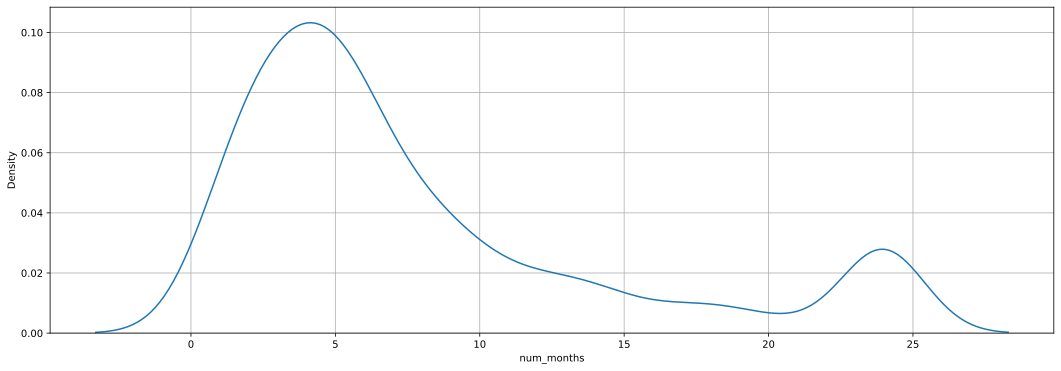

In [83]:
display_kde_plot(df, 'num_months')

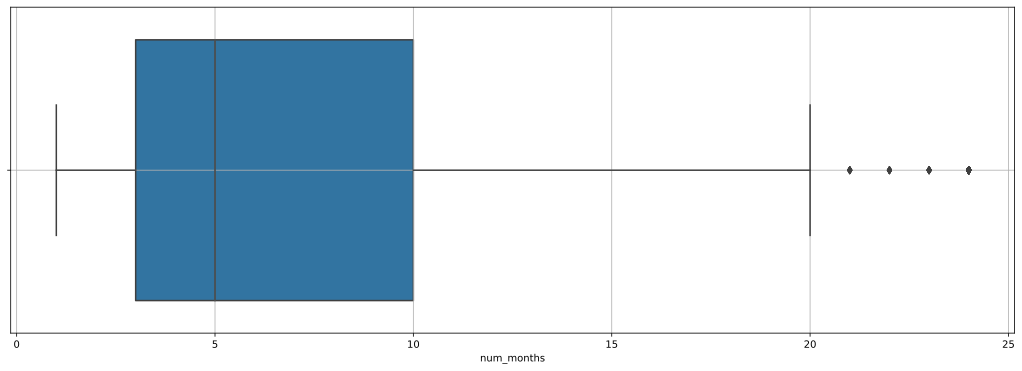

In [84]:
display_box_plot(df, 'num_months')

#### Tenure is a right skewed distribution with median tenure at about 5 months, it contains outliers on the right side

#### Age:

In [85]:
df['Age'].describe()

count    2381.000000
mean       33.149937
std         5.868427
min        21.000000
25%        29.000000
50%        33.000000
75%        37.000000
max        58.000000
Name: Age, dtype: float64

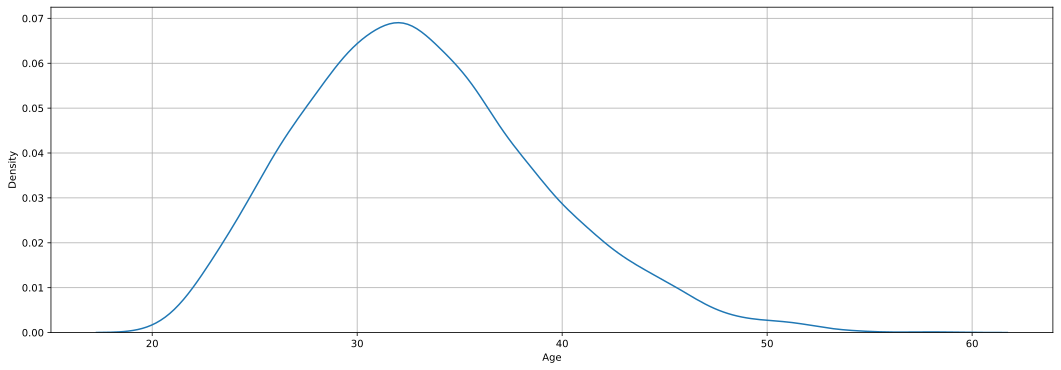

In [86]:
display_kde_plot(df, 'Age')

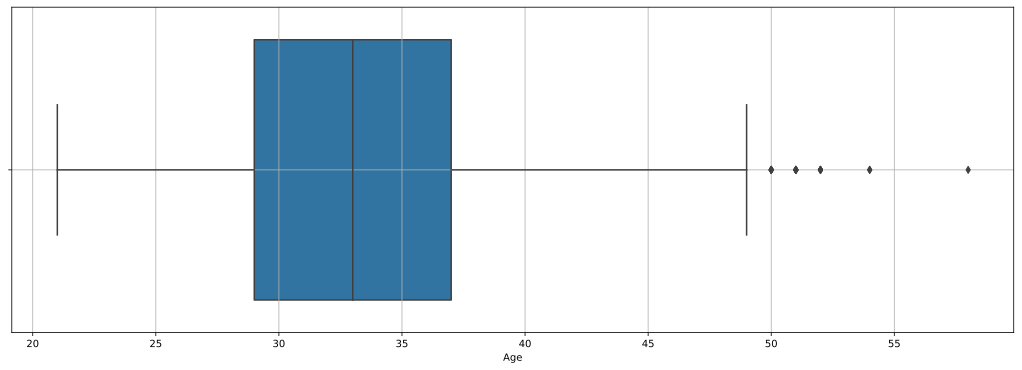

In [87]:
display_box_plot(df, 'Age')

#### Age is almost a symmetric distribution with some outliers on the RHS and median age is about 33

#### Gender:

In [89]:
display_normalized_value_counts(df, 'Gender')

Male      58.97
Female    41.03
Name: Gender, dtype: float64


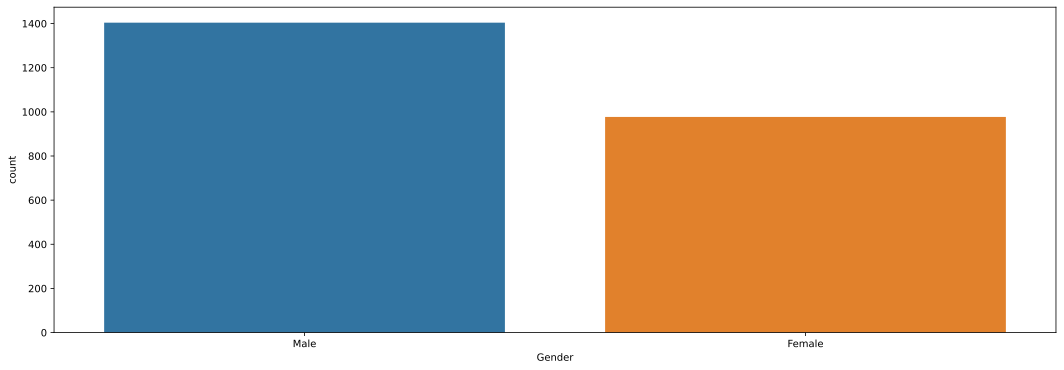

In [90]:
display_countplot(df, 'Gender')

#### Ratio of Male:Female in Ola drivers is 60:40 (which is reasonable as Driver profession is a male dominated industry)

#### City:

In [91]:
display_normalized_value_counts(df, "City")

C20    6.38
C15    4.24
C29    4.03
C26    3.91
C8     3.74
C27    3.74
C10    3.61
C16    3.53
C22    3.44
C3     3.44
C28    3.44
C12    3.40
C5     3.36
C1     3.36
C21    3.32
C14    3.32
C6     3.28
C4     3.23
C7     3.19
C9     3.15
C25    3.11
C23    3.11
C24    3.07
C19    3.02
C2     3.02
C17    2.98
C13    2.98
C18    2.90
C11    2.69
Name: City, dtype: float64


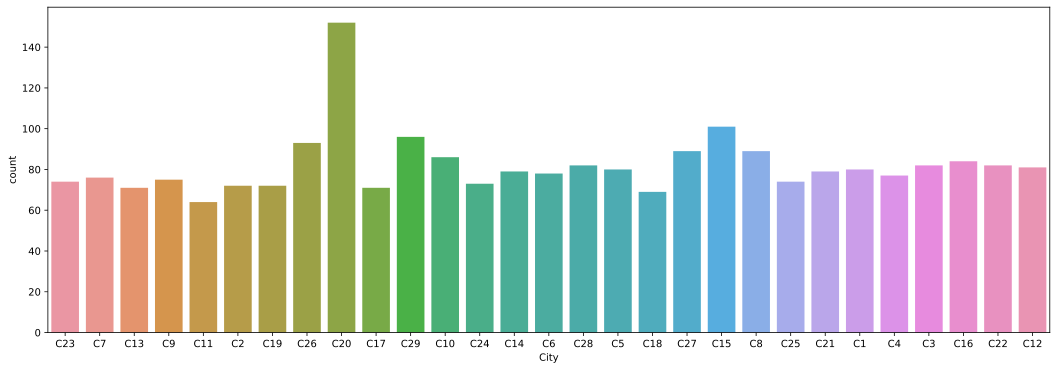

In [92]:
display_countplot(df, 'City')

#### Number of drivers across most cities is almost similar with the exception being C20 which contains approx. 6% of the drivers

#### Education Level:

In [93]:
display_normalized_value_counts(df, "Education_Level")

2    33.68
1    33.39
0    32.93
Name: Education_Level, dtype: float64


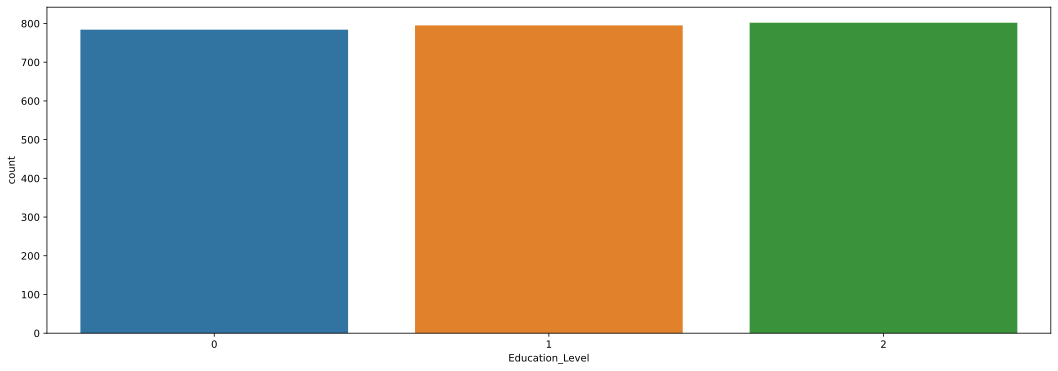

In [94]:
display_countplot(df, 'Education_Level')

#### There are equal proportion of drivers which studied upto 10th, upto 12th and those who are graduates

#### Joining Designation:

In [95]:
display_normalized_value_counts(df, "Joining_Designation")

1    43.09
2    34.23
3    20.71
4     1.51
5     0.46
Name: Joining_Designation, dtype: float64


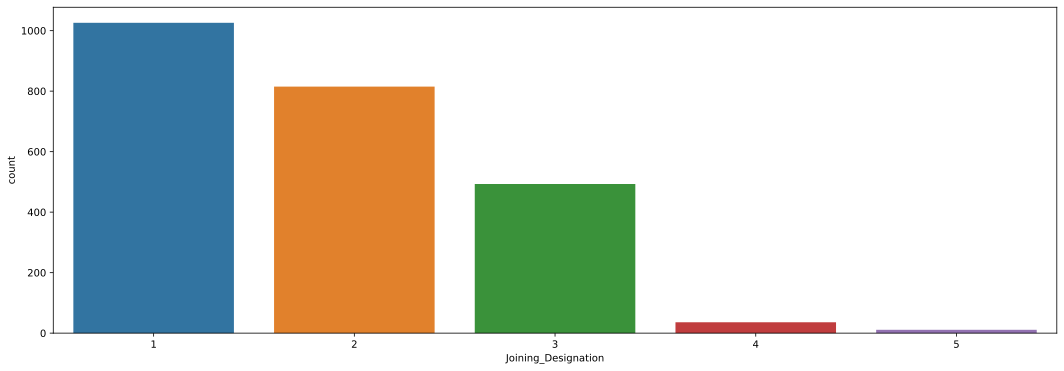

In [97]:
display_countplot(df, 'Joining_Designation')

#### 98% of the drivers join at designation 1, 2 or 3 while only 2% join at 4 or 5

#### DOJ Year:

In [98]:
display_normalized_value_counts(df, "DOJ_Year")

2020    34.36
2018    25.16
2019    24.82
2015     4.58
2016     4.54
2017     3.61
2013     1.72
2014     1.22
Name: DOJ_Year, dtype: float64


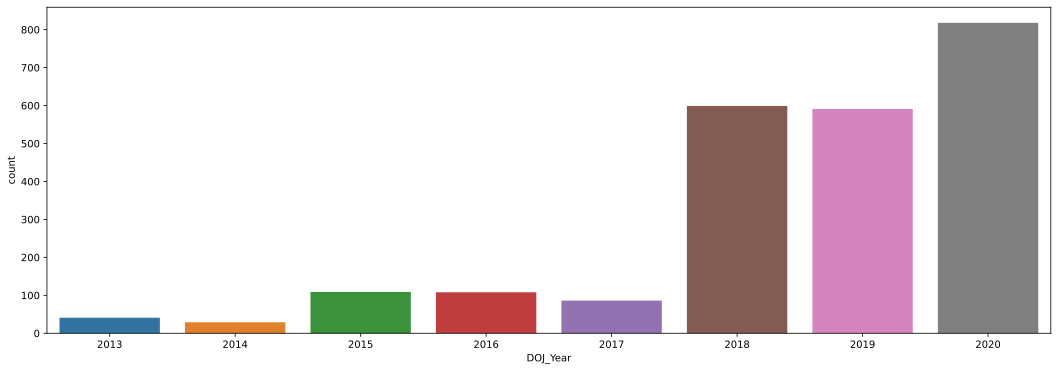

In [99]:
display_countplot(df, 'DOJ_Year')

#### 85% of the drivers joined in between 2018-2020

#### DOJ Month:

In [100]:
display_normalized_value_counts(df, "DOJ_Month")

July         11.72
May          10.33
June         10.08
November      9.87
October       9.70
September     8.74
August        8.69
December      7.48
January       7.06
April         7.01
February      4.91
March         4.41
Name: DOJ_Month, dtype: float64


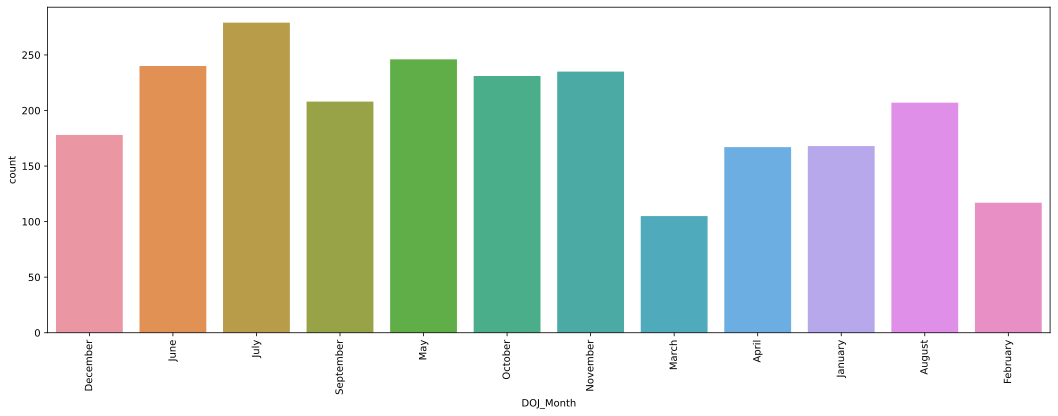

In [101]:
display_countplot(df, 'DOJ_Month', rot=True)

#### Number of people joining is highest in May-July while lowest in Feb-March

#### Average income:

In [102]:
df['avg_income'].describe()

count      2381.000000
mean      59272.610248
std       28325.327154
min       10747.000000
25%       39104.000000
50%       55285.000000
75%       75835.000000
max      188418.000000
Name: avg_income, dtype: float64

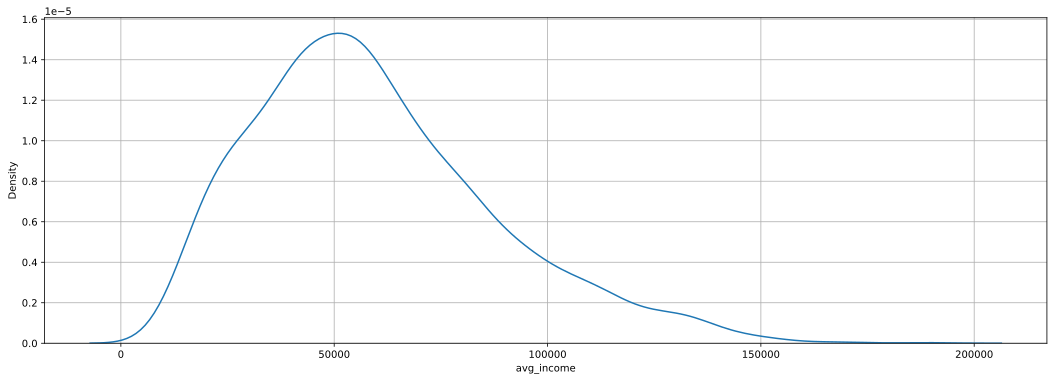

In [103]:
display_kde_plot(df, 'avg_income')

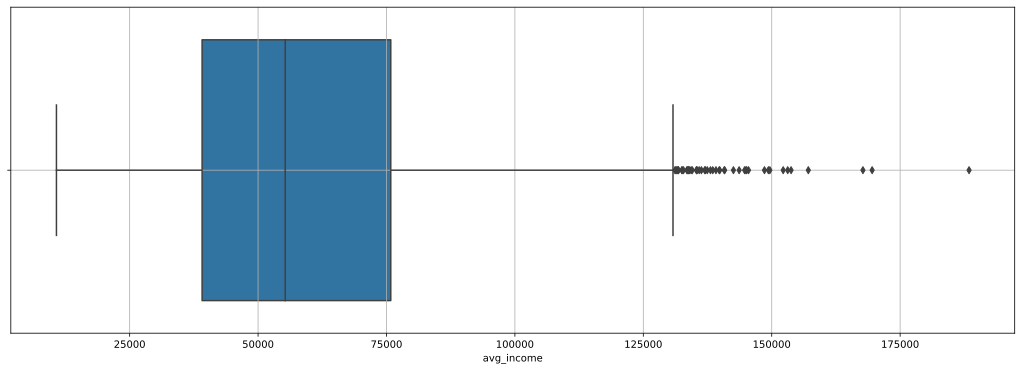

In [104]:
display_box_plot(df, 'avg_income')

#### This looks like a right tailed distribution with significant outliers on the RHS, median income is close to 50k

#### Income increase flag:

In [105]:
display_normalized_value_counts(df, "income_increase_flag")

0.0    98.15
1.0     1.85
Name: income_increase_flag, dtype: float64


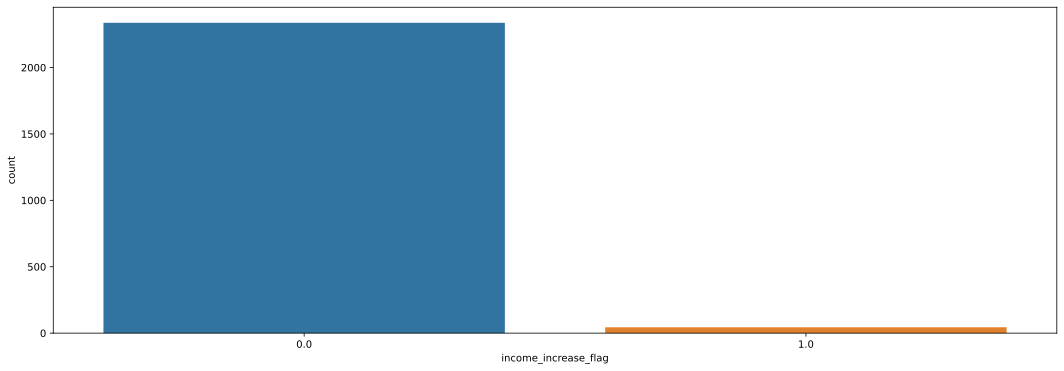

In [106]:
display_countplot(df, 'income_increase_flag')

#### For 98% of the drivers, income remained the same across their tenure at Ola, while for the rest 2%, income increased

#### Income difference between ultimate and penultimate months at OLA:

In [107]:
display_normalized_value_counts(df, "income_last_tenure_diff")

0    98.15
1     1.85
Name: income_last_tenure_diff, dtype: float64


#### It's better to drop this feature as this information is already captured in "income_increase_flag"


#### Average grade:

In [108]:
display_normalized_value_counts(df, "avg_grade")

2.0    35.45
1.0    31.12
3.0    25.28
4.0     5.42
2.5     0.92
5.0     0.88
1.5     0.42
3.5     0.38
4.5     0.13
Name: avg_grade, dtype: float64


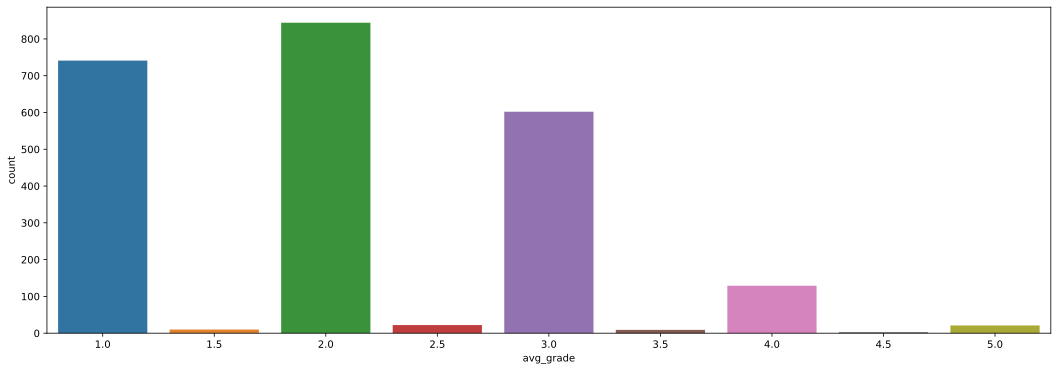

In [109]:
display_countplot(df, 'avg_grade')

#### This distribution is very similar to Joining Grade's distribution

####  Is Promoted:

In [110]:
display_normalized_value_counts(df, "is_promoted")

0    82.86
1    17.14
Name: is_promoted, dtype: float64


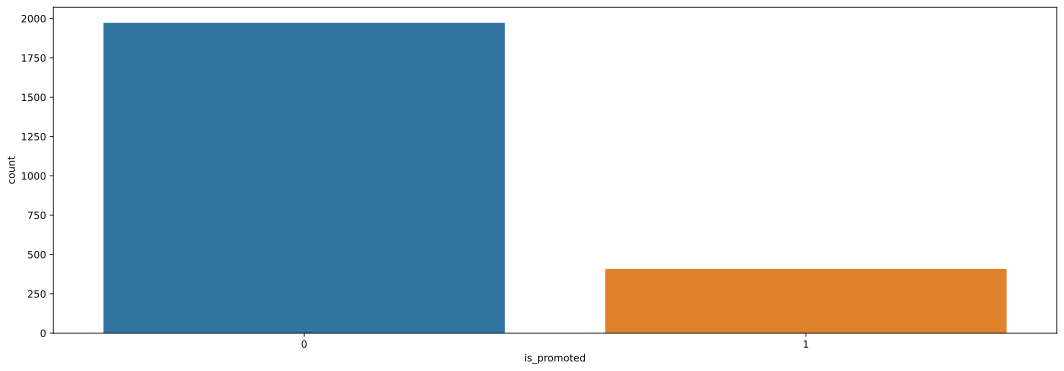

In [111]:
display_countplot(df, 'is_promoted')

#### 17% of the drivers have witnessed an increase in their grade while 83% remained at the same grade

#### Grade increase flag:

In [112]:
display_normalized_value_counts(df, "grade_increase_flag")

0.0    98.15
1.0     1.85
Name: grade_increase_flag, dtype: float64


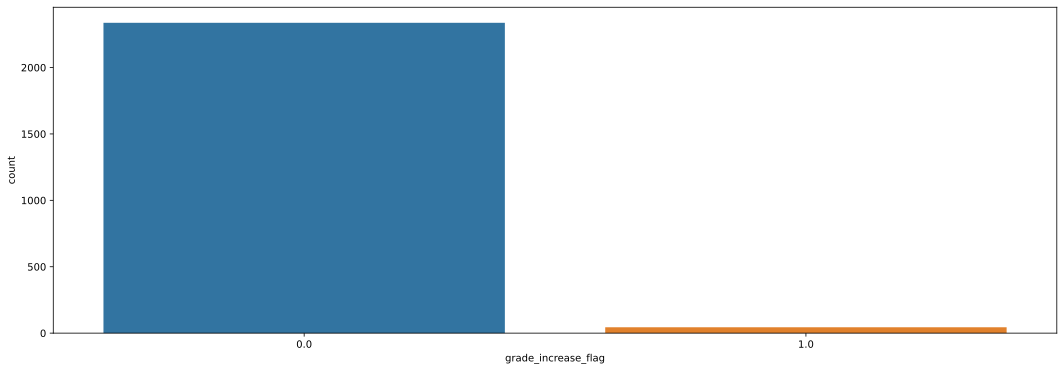

In [113]:
display_countplot(df, 'grade_increase_flag')

#### About 2% of the people witnessed an increase in their grades during subsequent months at OLA

#### Grade difference between ultimate and penultimate months at OLA:

In [114]:
display_normalized_value_counts(df, "grade_last_tenure_diff")

0    98.15
1     1.85
Name: grade_last_tenure_diff, dtype: float64


#### This is the same as 'grade_increase_flag' hence can be dropped 

#### Average total business value (TBV):

In [116]:
df['avg_total_business_value'].describe()

count    2.381000e+03
mean     3.745311e+05
std      4.994292e+05
min     -2.771060e+05
25%      0.000000e+00
50%      2.239375e+05
75%      5.325633e+05
max      4.333230e+06
Name: avg_total_business_value, dtype: float64

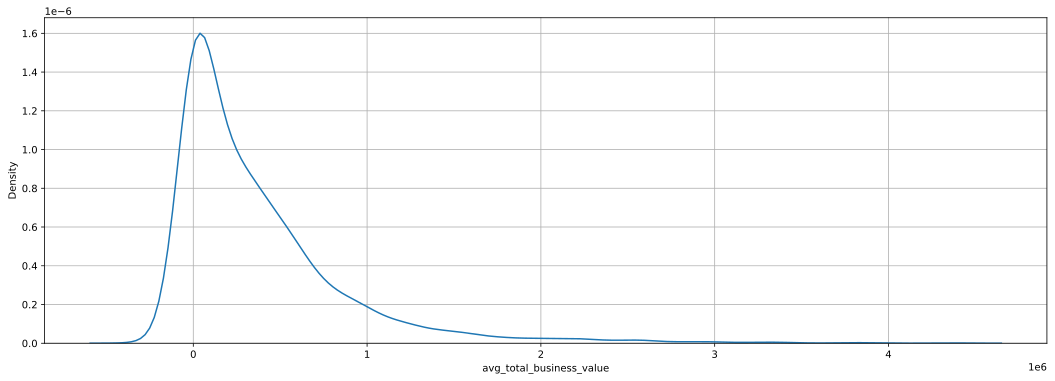

In [117]:
display_kde_plot(df, 'avg_total_business_value')

#### This is a clear right tailed distribution containig severe outliers on the RHS (median TBV is about 2.25 Lakhs while max goes upto 43 Lakhs)

#### TBV increase flag:

In [118]:
df['total_business_value_increase_flag'].describe()

count    2381.000000
mean        0.122662
std         0.439303
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.250000
max         1.000000
Name: total_business_value_increase_flag, dtype: float64

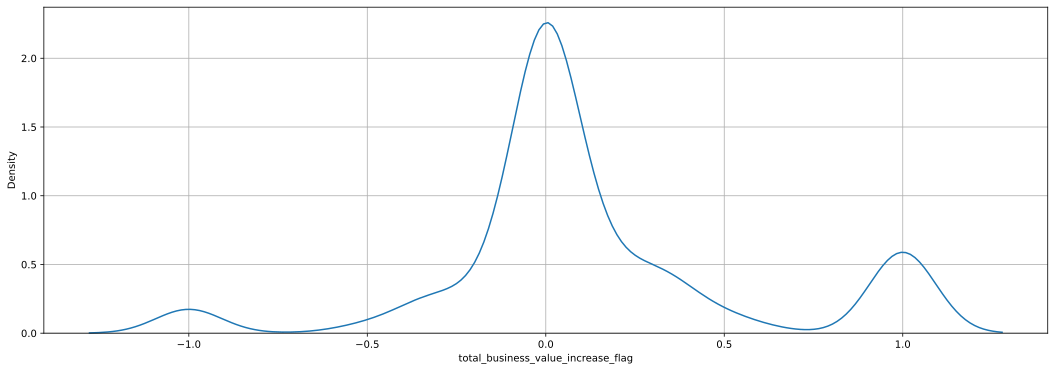

In [119]:
display_kde_plot(df, 'total_business_value_increase_flag')

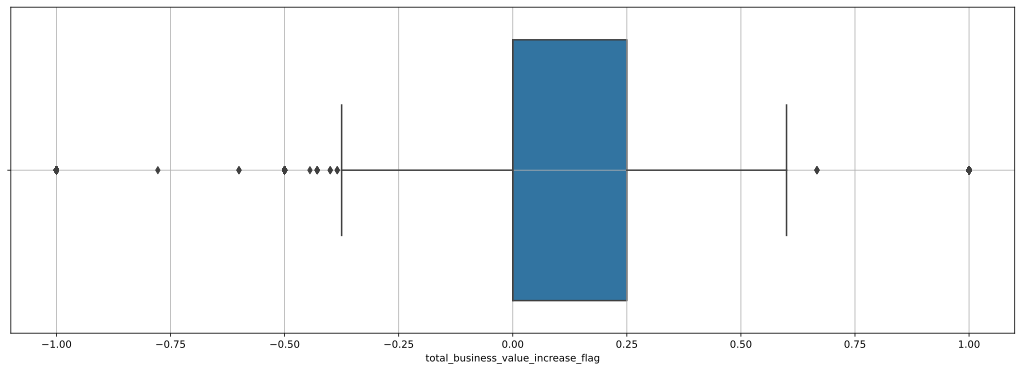

In [120]:
display_box_plot(df, 'total_business_value_increase_flag')

#### This looks like an almost symmetric distribution

#### TBV difference between ultimate and penultimate months at OLA:

In [121]:
display_normalized_value_counts(df, "total_business_value_last_tenure_diff")

-1    35.95
 1    33.98
 0    30.07
Name: total_business_value_last_tenure_diff, dtype: float64


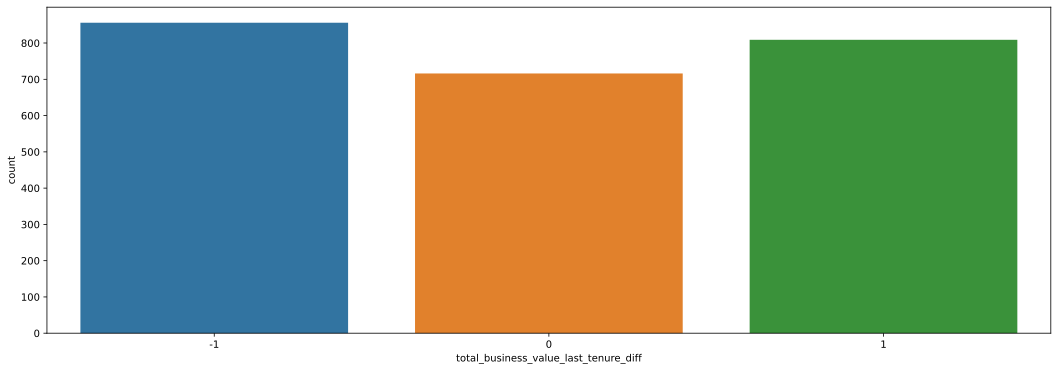

In [122]:
display_countplot(df, 'total_business_value_last_tenure_diff')

#### The distribution among people who incurred a decreased in TBV, who incurred an increase in TBV and for those whom TBV remained same is approximately the same.

#### Average quarterly rating:

In [123]:
df['avg_quarterly_rating'].describe()

count    2381.000000
mean        1.536679
std         0.672356
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: avg_quarterly_rating, dtype: float64

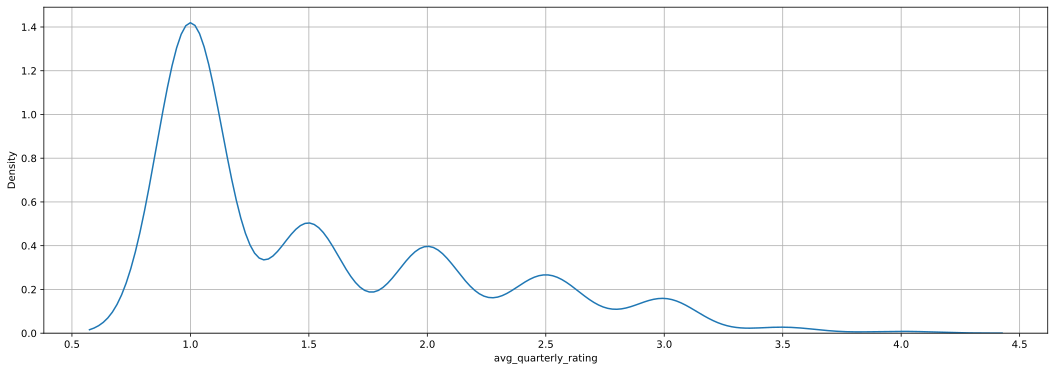

In [124]:
display_kde_plot(df, 'avg_quarterly_rating')

#### Quarterly rating increase flag:

In [125]:
display_normalized_value_counts(df, "quarterly_rating_increase_flag")

 0.000000    61.57
 1.000000    19.49
-1.000000    15.92
 0.333333     1.64
-0.333333     1.39
Name: quarterly_rating_increase_flag, dtype: float64


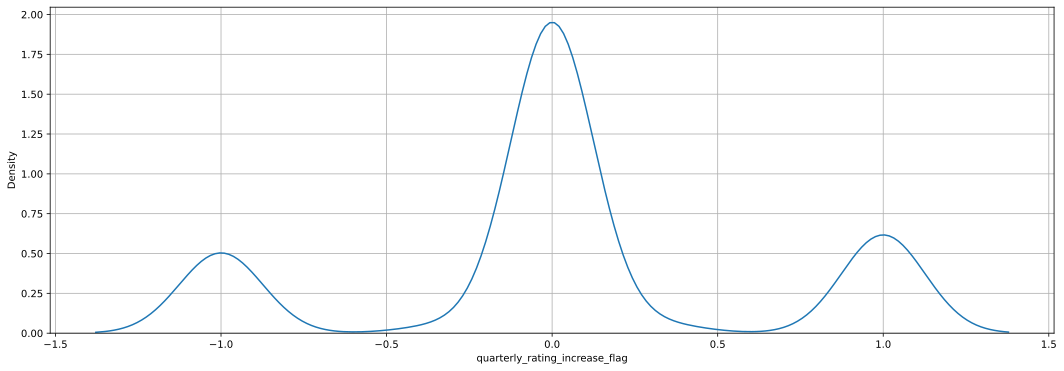

In [126]:
display_kde_plot(df, 'quarterly_rating_increase_flag')

#### Quarterly rating difference between ultimate and penultimate months at OLA:

In [127]:
display_normalized_value_counts(df, "quarterly_rating_last_tenure_diff")

 0    53.63
-1    23.48
 1    22.89
Name: quarterly_rating_last_tenure_diff, dtype: float64


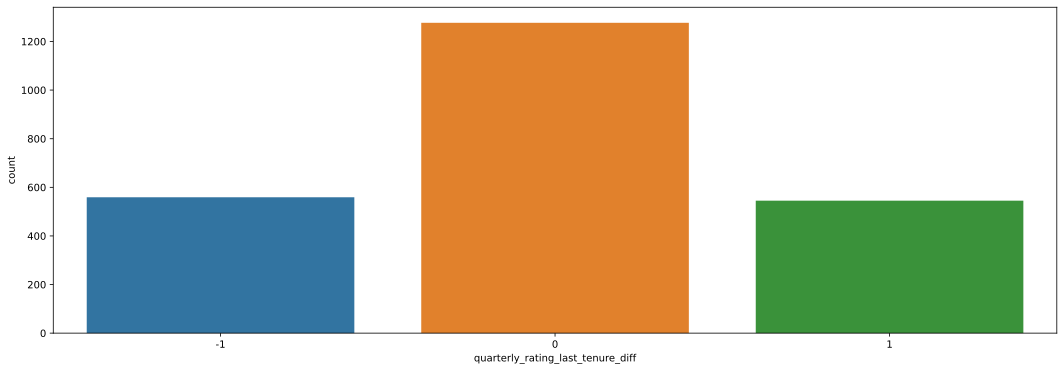

In [128]:
display_countplot(df, 'quarterly_rating_last_tenure_diff')

#### For about 50% of the people, the quarterly rating remained same for the last 2 tenures, for about 25% of the people, quarterly ratings increased and for about 25% of the people, quarterly ratings decreased

#### Is churned ?

In [129]:
display_normalized_value_counts(df, "churned")

1    67.87
0    32.13
Name: churned, dtype: float64


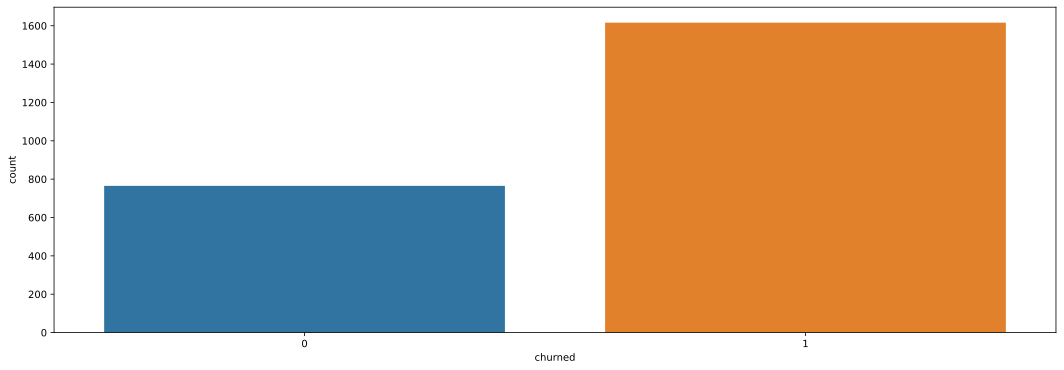

In [130]:
display_countplot(df, 'churned')

#### The churn rate is very high (68%), only 32% of the drivers did not churn

### Bivariate Analysis:

In [131]:
plt.rcParams["figure.figsize"] = (18,6)

In [132]:
df.columns

Index(['num_months', 'Age', 'Gender', 'City', 'Education_Level',
       'Joining_Designation', 'DOJ_Year', 'DOJ_Month', 'avg_income',
       'income_increase_flag', 'income_last_tenure_diff', 'avg_grade',
       'grade_increase_flag', 'grade_last_tenure_diff',
       'avg_total_business_value', 'total_business_value_increase_flag',
       'total_business_value_last_tenure_diff', 'avg_quarterly_rating',
       'quarterly_rating_increase_flag', 'quarterly_rating_last_tenure_diff',
       'is_promoted', 'churned', 'index'],
      dtype='object')

#### Number of months spent:

In [133]:
display_pearson_corr_coef(df, 'num_months', 'churned')

PCC between 'num_months' and 'churned' = -0.346


In [134]:
display_spearman_rank_corr_coef(df, 'num_months', 'churned')

SRCC between 'num_months' and 'churned' = -0.204


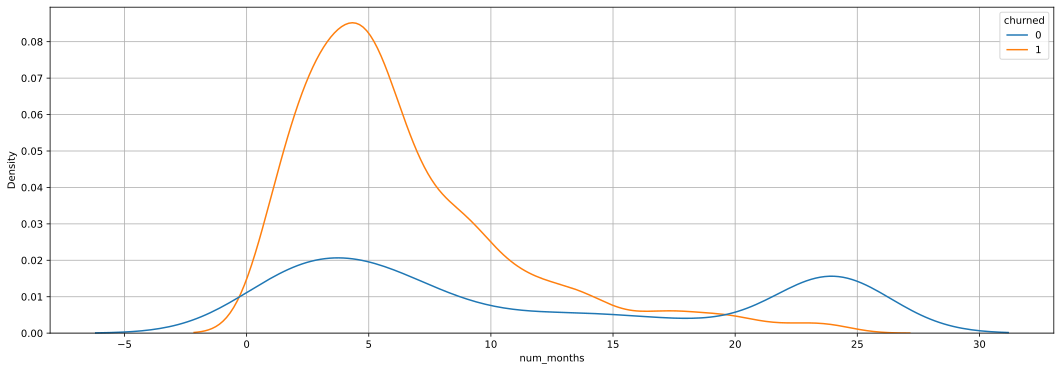

In [135]:
display_kde_plot_with_hue(df, 'num_months', 'churned')

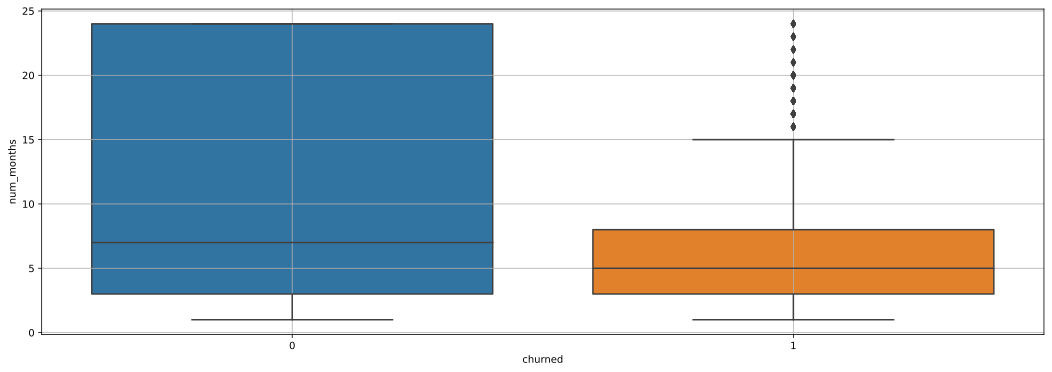

In [136]:
display_box_plot_2d(df, 'churned', 'num_months')

#### Although there's a weak correlation but still we can say that churned drivers spend less amount of time at the company as compared to non churned drivers and hence this seems like an important feature

#### Age:

In [137]:
display_pearson_corr_coef(df, 'Age', 'churned')

PCC between 'Age' and 'churned' = -0.056


In [138]:
display_spearman_rank_corr_coef(df, 'Age', 'churned')

SRCC between 'Age' and 'churned' = -0.065


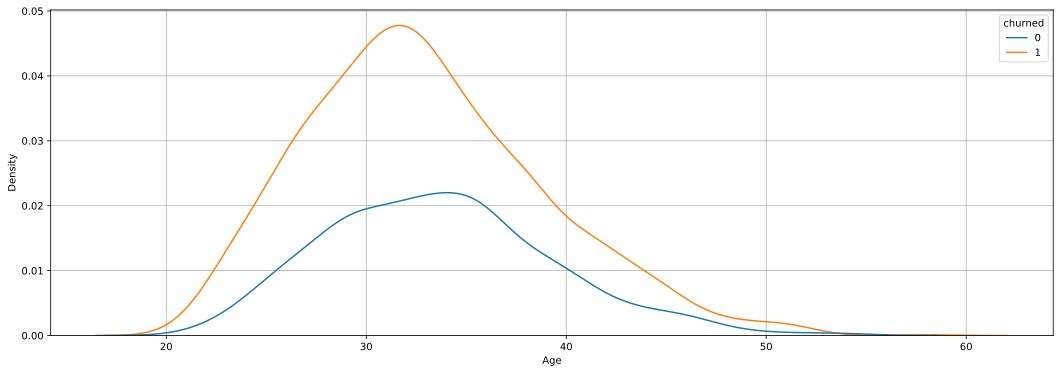

In [139]:
display_kde_plot_with_hue(df, 'Age', 'churned')

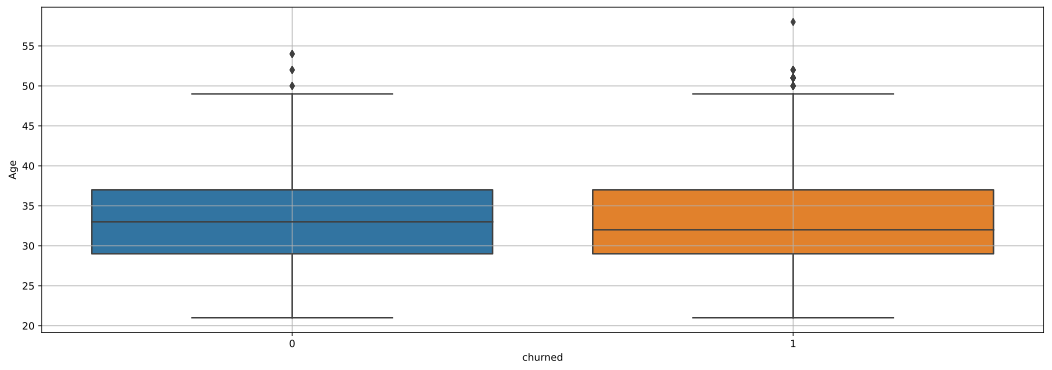

In [140]:
display_box_plot_2d(df, 'churned', 'Age')

#### The plots are almost overlapping, this does not seem like an important feature

#### Gender:

In [143]:
display_grouped_value_counts_percentage(df, 'Gender')

,Gender,churned,percentage
0,Female,0,31.63
1,Female,1,68.37
2,Male,0,32.48
3,Male,1,67.52


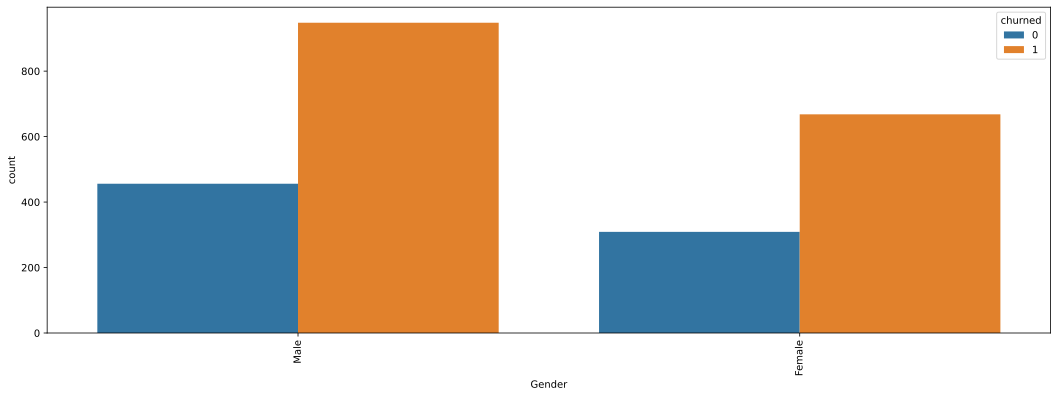

In [144]:
display_countplot_with_hue(df, 'Gender', 'churned',)

#### The ratio of churned:non churned is almost the same across both genders, this does not seem as an important feature 

#### City:

In [145]:
display_grouped_value_counts_percentage(df, 'City')

,City,churned,percentage
0,C1,0,30.00
1,C1,1,70.00
2,C10,0,29.07
3,C10,1,70.93
4,C11,0,29.69
5,C11,1,70.31
6,C12,0,34.57
7,C12,1,65.43
8,C13,0,18.31
9,C13,1,81.69


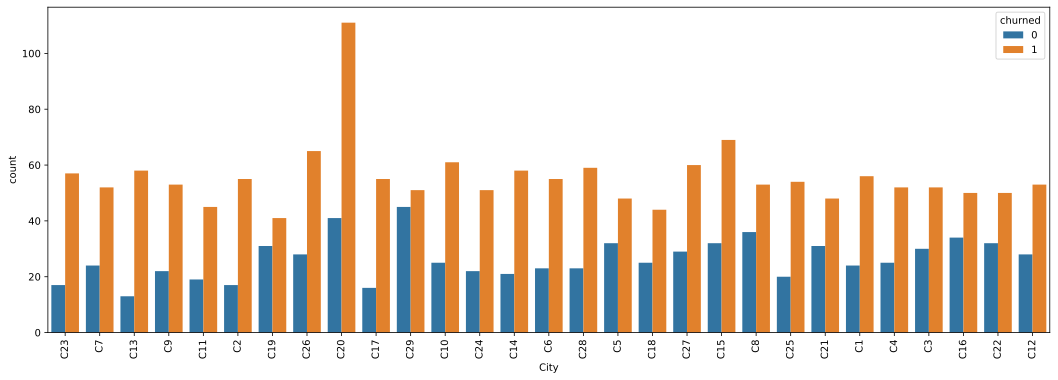

In [146]:
display_countplot_with_hue(df, 'City', 'churned')

#### There is variation among churn rate across different cities, this is definitely an important feature

#### Education Level:

In [147]:
display_grouped_value_counts_percentage(df, 'Education_Level')

,Education_Level,churned,percentage
0,0,0,30.87
1,0,1,69.13
2,1,0,33.71
3,1,1,66.29
4,2,0,31.80
5,2,1,68.20


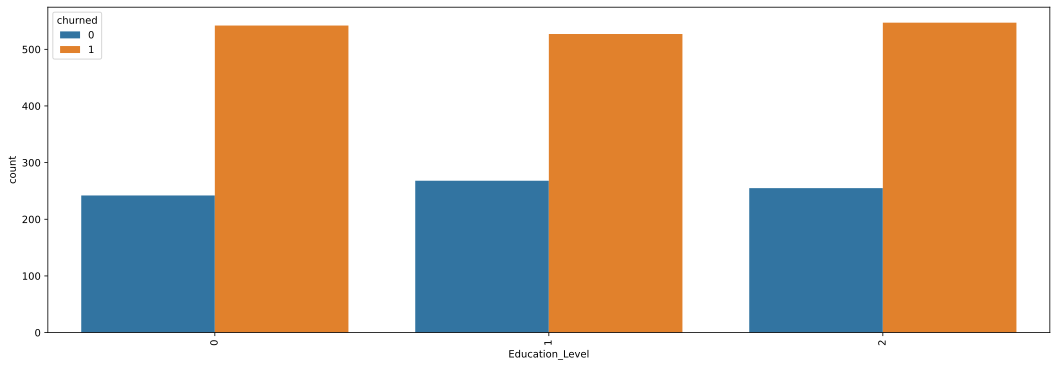

In [148]:
display_countplot_with_hue(df, 'Education_Level', 'churned')

#### Churn rate is almost the same across different education levels, this does not seem like an important feature

#### Joining Designation:

In [150]:
df['Joining_Designation'].value_counts()

1    1026
2     815
3     493
4      36
5      11
Name: Joining_Designation, dtype: int64

In [153]:
display_normalized_value_counts(df, "Joining_Designation")

1    43.09
2    34.23
3    20.71
4     1.51
5     0.46
Name: Joining_Designation, dtype: float64


In [155]:
display_grouped_value_counts_percentage(df, 'Joining_Designation')

,Joining_Designation,churned,percentage
0,1,0,26.71
1,1,1,73.29
2,2,0,31.29
3,2,1,68.71
4,3,0,44.42
5,3,1,55.58
6,4,0,38.89
7,4,1,61.11
8,5,0,27.27
9,5,1,72.73


In [156]:
display_pearson_corr_coef(df, 'Joining_Designation', 'churned')

PCC between 'Joining_Designation' and 'churned' = -0.128


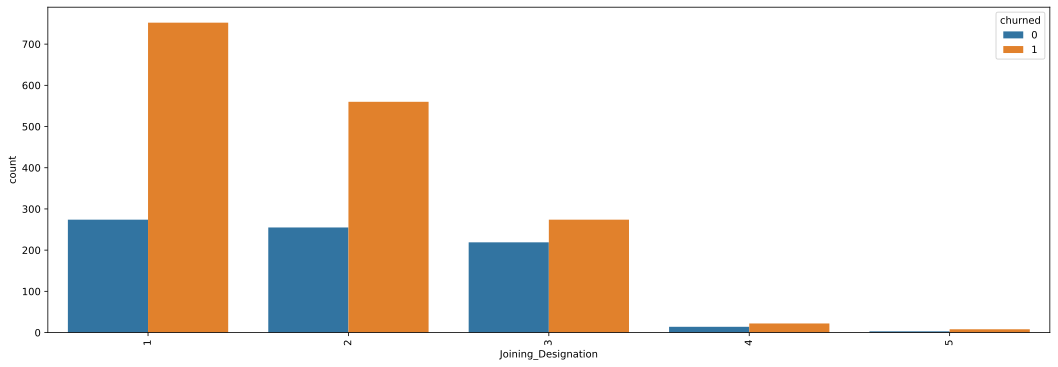

In [157]:
display_countplot_with_hue(df, 'Joining_Designation', 'churned')

#### Churn rate generally decreases as we go up the designation (designations 4 and 5 have less datapoints so they can be outliers also)

#### DOJ Year:

In [158]:
display_grouped_value_counts_percentage(df, 'DOJ_Year')

,DOJ_Year,churned,percentage
0,2013,0,39.02
1,2013,1,60.98
2,2014,0,72.41
3,2014,1,27.59
4,2015,0,50.46
5,2015,1,49.54
6,2016,0,37.96
7,2016,1,62.04
8,2017,0,23.26
9,2017,1,76.74


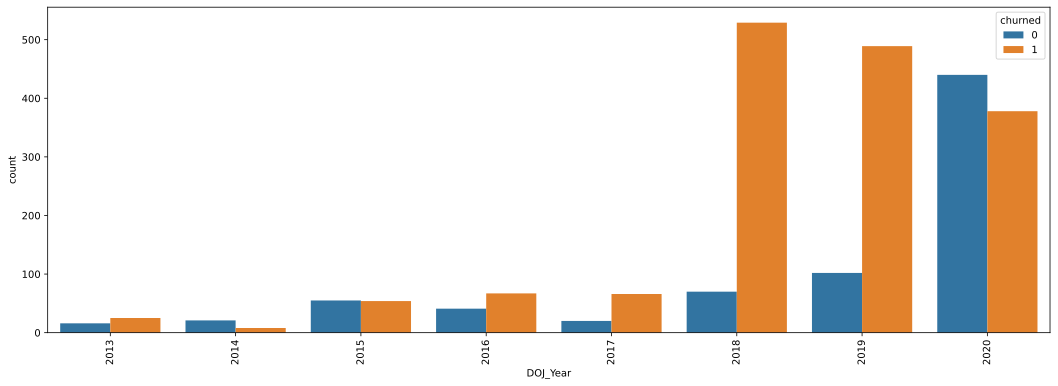

In [159]:
display_countplot_with_hue(df, 'DOJ_Year', 'churned')

#### There is significant variation among Year of Joining, hence seems an important feature

#### DOJ Month:

In [160]:
dfg_month = display_grouped_value_counts_percentage(df, 'DOJ_Month')
dfg_month['numerical_month'] = dfg_month['DOJ_Month'].apply(lambda x: list(calendar.month_name).index(x))
dfg_month.sort_values(by=['numerical_month', 'churned'], inplace=True)
dfg_month = dfg_month.drop(columns=['numerical_month']).reset_index(drop=True)

dfg_month

,DOJ_Month,churned,percentage
0,January,0,25.60
1,January,1,74.40
2,February,0,25.64
3,February,1,74.36
4,March,0,27.62
5,March,1,72.38
6,April,0,35.93
7,April,1,64.07
8,May,0,23.98
9,May,1,76.02


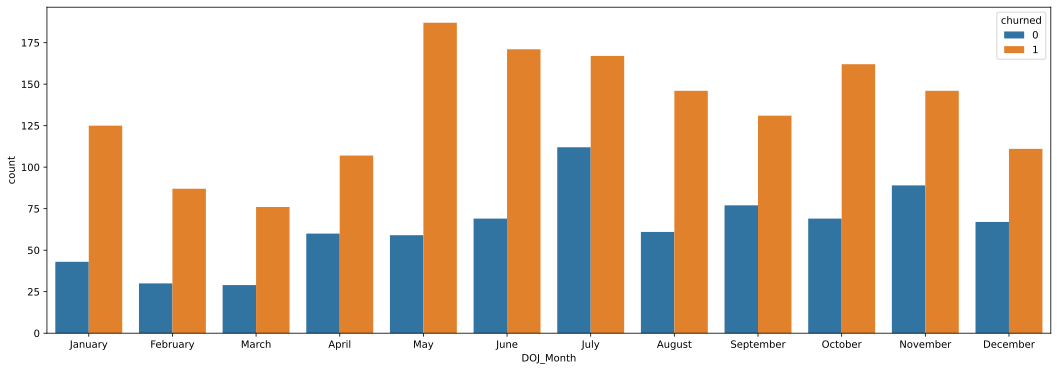

In [163]:
display_countplot_with_hue(
    df, 'DOJ_Month', 'churned',
    order_col=list(calendar.month_name)[1:]
)

#### There seems variation in the churn rate based on the Joining month, this seems an important feature

#### Average income:

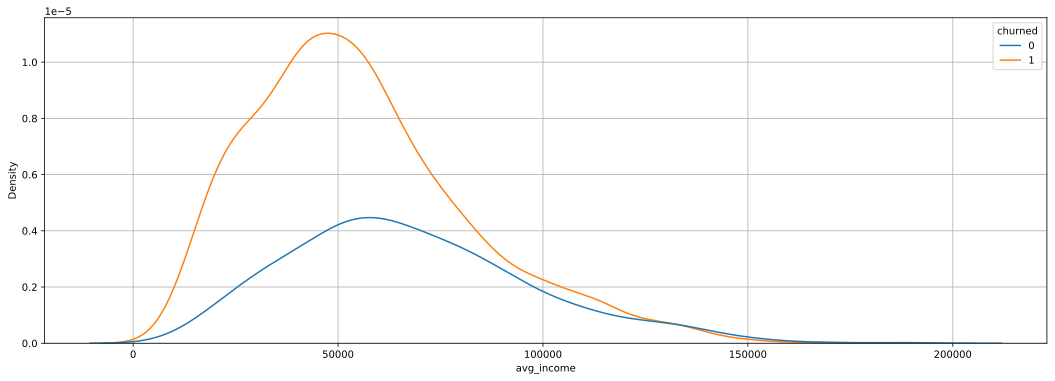

In [164]:
display_kde_plot_with_hue(df, 'avg_income', 'churned')

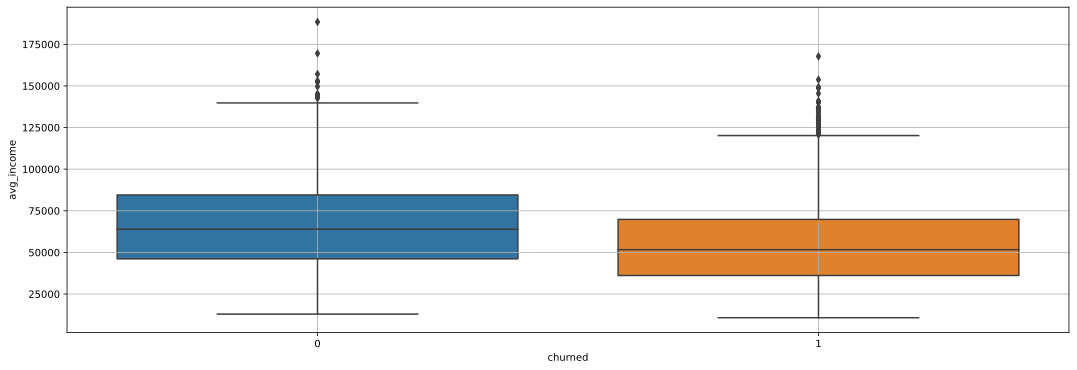

In [165]:
display_box_plot_2d(df, 'churned', 'avg_income')

#### Average income of churned drivers is slighly less as compared to non churned drivers

#### Income increase flag:

In [166]:
display_grouped_value_counts_percentage(df, 'income_increase_flag')

,income_increase_flag,churned,percentage
0,0.0,0,30.98
1,0.0,1,69.02
2,1.0,0,93.18
3,1.0,1,6.82


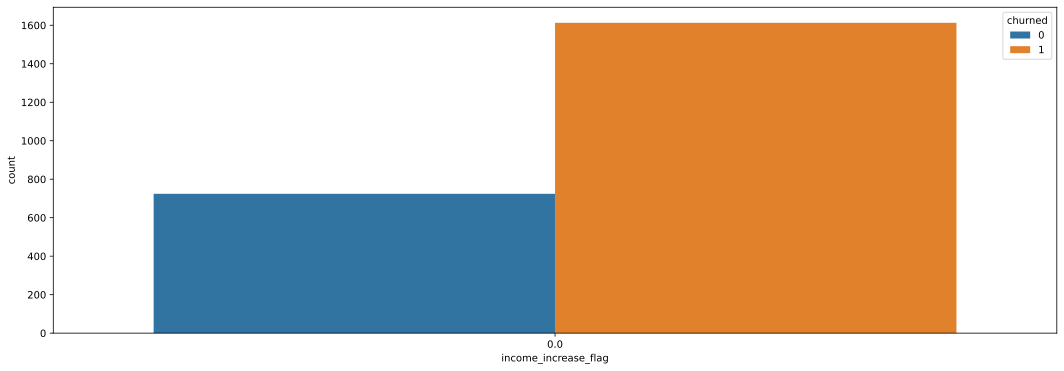

In [167]:
display_countplot_with_hue(df[df['income_increase_flag']==0],'income_increase_flag', 'churned')

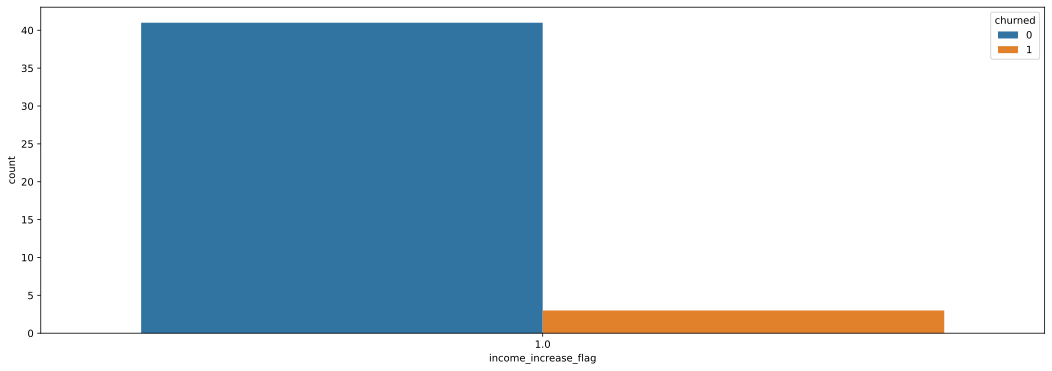

In [168]:
display_countplot_with_hue(df[df['income_increase_flag']==1],'income_increase_flag', 'churned')

#### The churn rate is very low (7%) when income_increase_flag = 1 as compared to 70% rate when income_increase_flag = 0

#### Average grade:

In [169]:
display_grouped_value_counts_percentage(df, 'avg_grade')

,avg_grade,churned,percentage
0,1.0,0,19.57
1,1.0,1,80.43
2,1.5,0,100.00
3,2.0,0,28.91
4,2.0,1,71.09
5,2.5,0,95.45
6,2.5,1,4.55
7,3.0,0,44.19
8,3.0,1,55.81
9,3.5,0,88.89


In [170]:
display_pearson_corr_coef(df, 'avg_grade', 'churned')

PCC between 'avg_grade' and 'churned' = -0.215


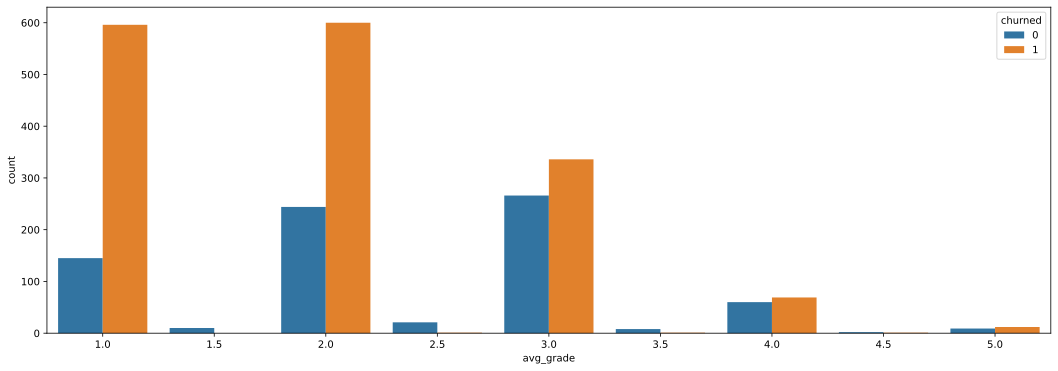

In [171]:
display_countplot_with_hue(df, 'avg_grade', 'churned')

#### There seems variation in the avg_grade with churn rate (churn rate decreases as average grade increases), this seems an important feature

#### Is Promoted ?

In [172]:
display_grouped_value_counts_percentage(df, 'is_promoted')

,is_promoted,churned,percentage
0,0,0,29.30
1,0,1,70.70
2,1,0,45.83
3,1,1,54.17


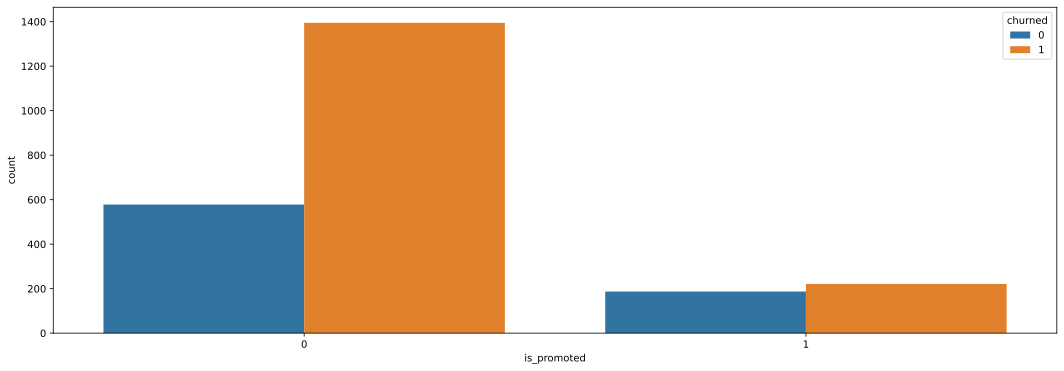

In [173]:
display_countplot_with_hue(df, 'is_promoted', 'churned')

#### Churned rate is significantly lower when the driver has been promoted during his tenure at OLA

#### Grade increase flag:

In [174]:
display_grouped_value_counts_percentage(df, 'grade_increase_flag')

,grade_increase_flag,churned,percentage
0,0.0,0,30.98
1,0.0,1,69.02
2,1.0,0,93.18
3,1.0,1,6.82


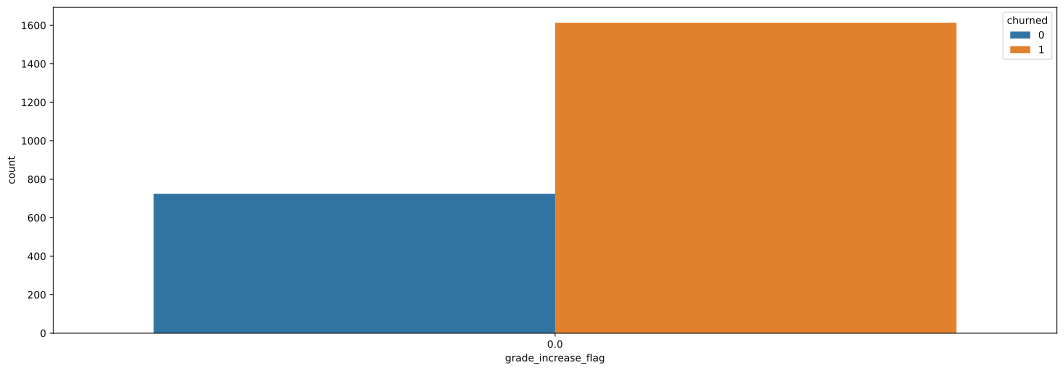

In [175]:
display_countplot_with_hue(df[df['grade_increase_flag']==0],'grade_increase_flag', 'churned')

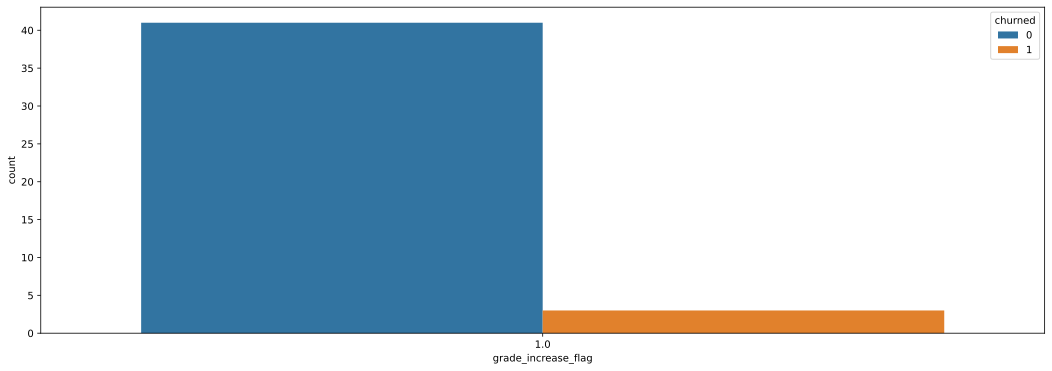

In [176]:
display_countplot_with_hue(df[df['grade_increase_flag']==1],'grade_increase_flag', 'churned')

#### The churn rate is very low (7%) when grade_increase_flag = 1 as compared to 70% rate when grade_increase_flag = 0

#### Average total business value (TBV):

In [177]:
display_pearson_corr_coef(df, 'avg_total_business_value', 'churned')

PCC between 'avg_total_business_value' and 'churned' = -0.308


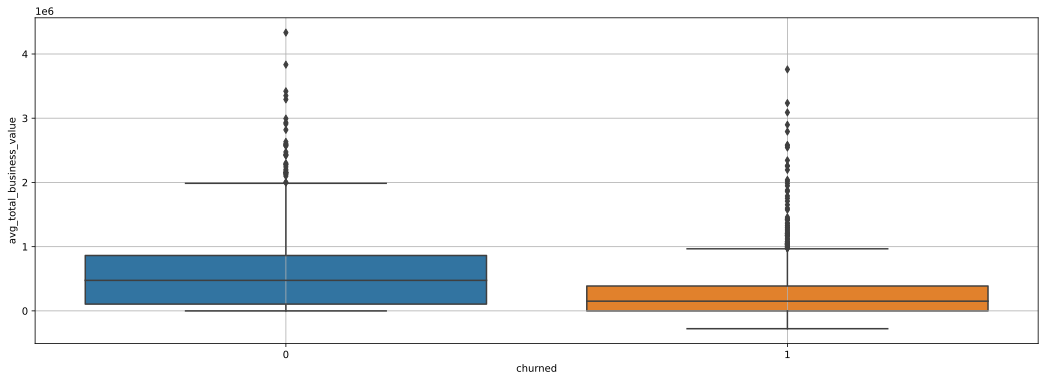

In [178]:
display_box_plot_2d(df, 'churned', 'avg_total_business_value')

#### Average total business value is significantly less for churned drivers (negative correlation also indicates the same), hence this seems an important feature

#### TBV increase flag:

In [179]:
display_pearson_corr_coef(df, 'total_business_value_increase_flag', 'churned')

PCC between 'total_business_value_increase_flag' and 'churned' = -0.132


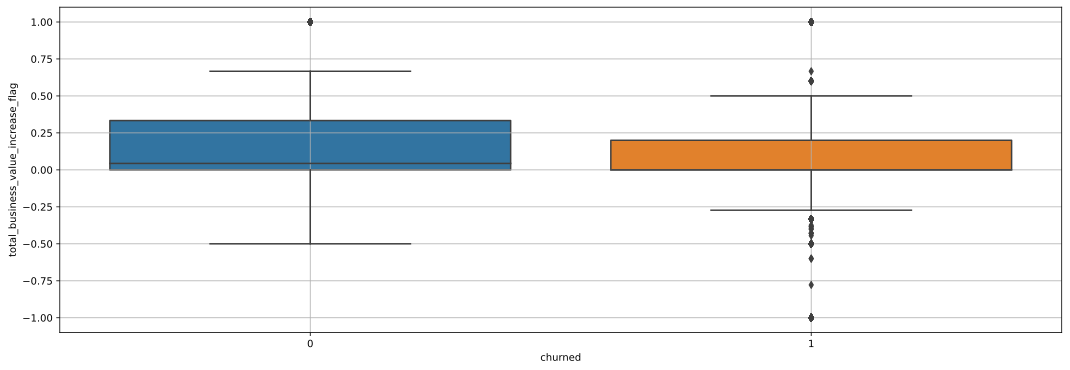

In [180]:
display_box_plot_2d(df, 'churned', 'total_business_value_increase_flag')

#### There's slight difference but it doesn't seem to be significant

#### TBV difference between ultimate and penultimate months at OLA:

In [181]:
display_grouped_value_counts_percentage(df, 'total_business_value_last_tenure_diff')

,total_business_value_last_tenure_diff,churned,percentage
0,-1,0,25.00
1,-1,1,75.00
2,0,0,23.60
3,0,1,76.40
4,1,0,47.22
5,1,1,52.78


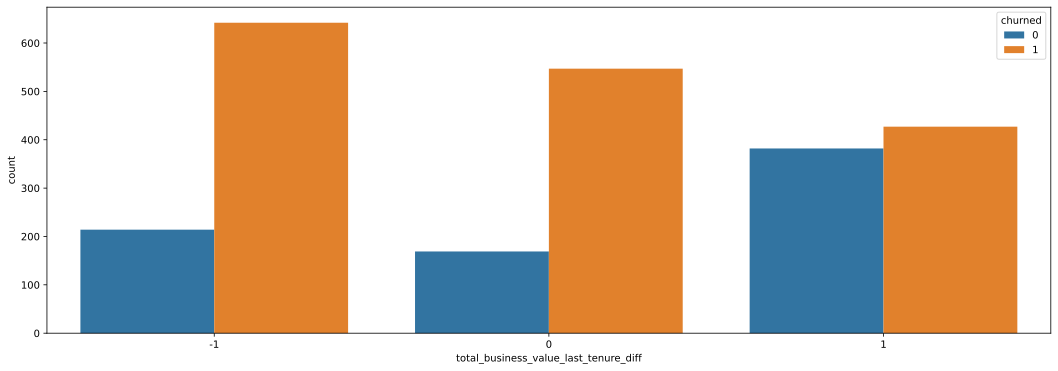

In [182]:
display_countplot_with_hue(df, 'total_business_value_last_tenure_diff', 'churned')

#### Churn rate is significantly lower when TBV has increased in the last month as compared to the previous month, this seems an important feature

#### Average quarterly rating:

In [183]:
display_pearson_corr_coef(df, 'avg_quarterly_rating', 'churned')

PCC between 'avg_quarterly_rating' and 'churned' = -0.376


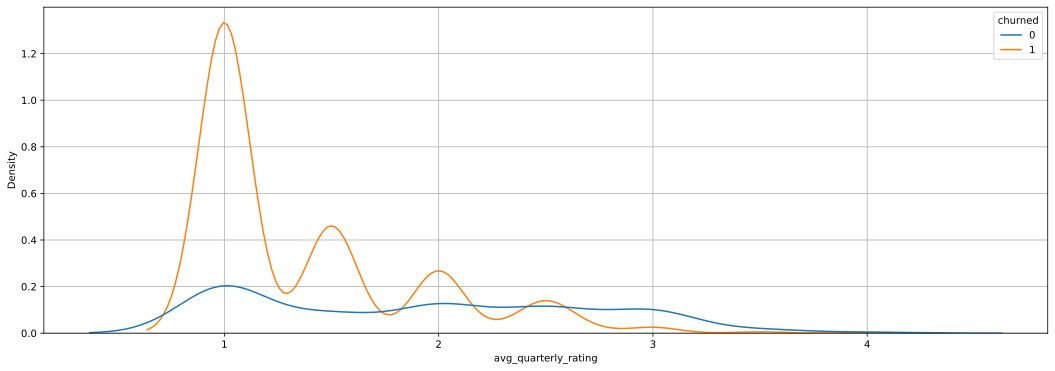

In [184]:
display_kde_plot_with_hue(df, 'avg_quarterly_rating', 'churned')

#### Negative correlation indicates that as average quarterly ratings increase, churn rate decreases

#### Quarterly rating increase flag:

In [185]:
display_spearman_rank_corr_coef(df, 'quarterly_rating_increase_flag', 'churned')

SRCC between 'quarterly_rating_increase_flag' and 'churned' = -0.237


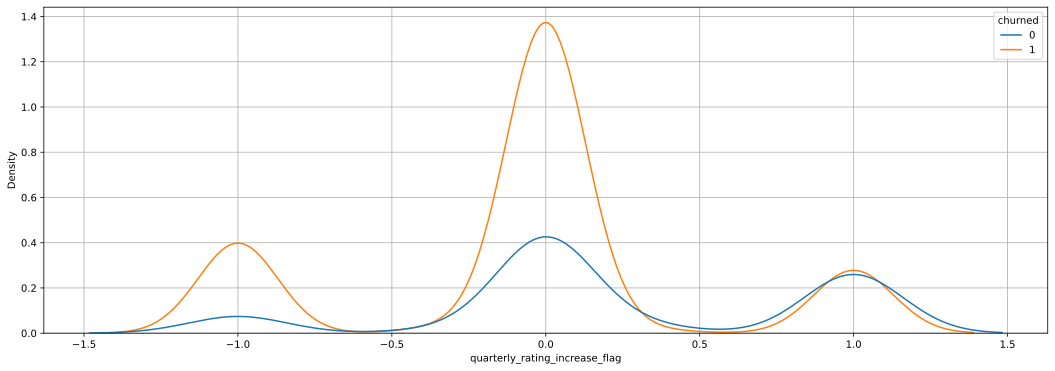

In [186]:
display_kde_plot_with_hue(df, 'quarterly_rating_increase_flag', 'churned')

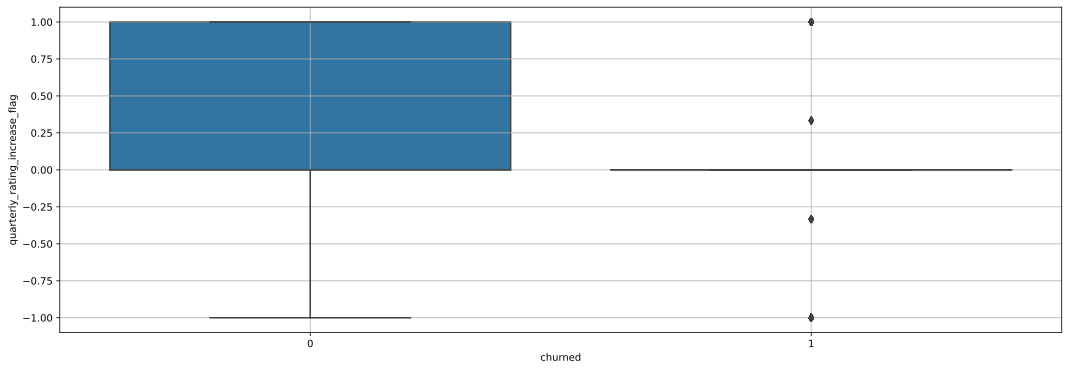

In [187]:
display_box_plot_2d(df, 'churned', 'quarterly_rating_increase_flag')

#### As quarterly ratings increase, churn rate decreases however the plot doesn't look stable.

#### Quarterly rating difference between ultimate and penultimate months at OLA:

In [188]:
display_grouped_value_counts_percentage(df, 'quarterly_rating_last_tenure_diff')

,quarterly_rating_last_tenure_diff,churned,percentage
0,-1,0,30.77
1,-1,1,69.23
2,0,0,22.79
3,0,1,77.21
4,1,0,55.41
5,1,1,44.59


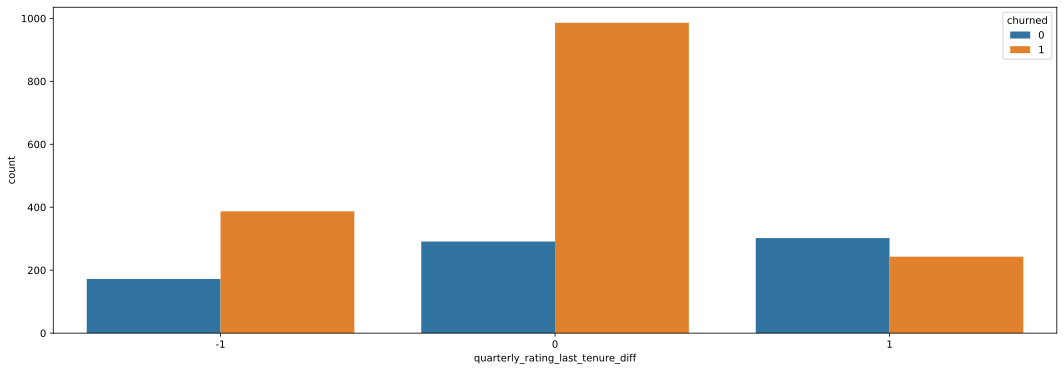

In [189]:
display_countplot_with_hue(df, 'quarterly_rating_last_tenure_diff', 'churned')

#### The churn rate is significantly lower when the quarterly rating has increased over the last month, hence this seems an important feature

### Correlation Heatmap:

In [191]:
corr_df = df[[
    'num_months', 'Age', 'Education_Level', 'Joining_Designation', 'avg_income',
    'income_increase_flag', 'avg_grade', 'avg_total_business_value', 'total_business_value_increase_flag',
    'total_business_value_last_tenure_diff', 'avg_quarterly_rating', 'quarterly_rating_increase_flag',
    'is_promoted', 'Gender', 'grade_increase_flag', 'grade_last_tenure_diff',
    'quarterly_rating_last_tenure_diff', 'income_last_tenure_diff', 'churned'
]]

corr_df['Gender'] = corr_df['Gender'].map({'Female' : 0, 'Male' : 1})

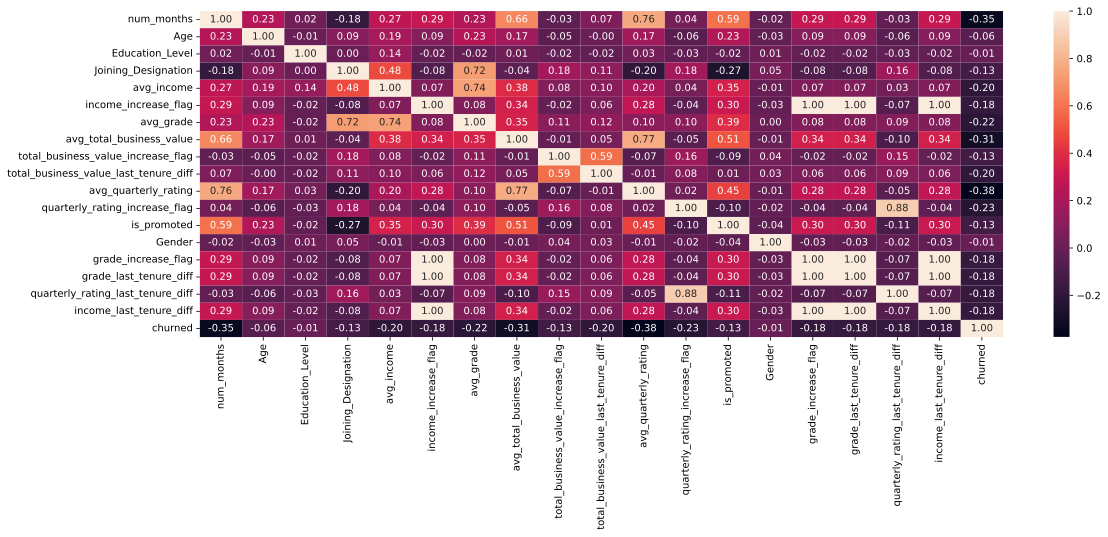

In [192]:
display_correlation_plot(corr_df)

#### Key Observations:

1. The more months the driver spends at Ola, lower is the churn rate
2. Higher the avg quarterly rating, lower is the churn rate
3. Higher the avg business value, lower is the churn rate
4. Most of the increase_flag and last_tenure_diff variables have high correlation among themselves so we can drop some of these
5. Age, Education level and Gender have very less correlation with churn and hence can be dropped

## Data Preprocessing:
#### [ Train | Cross Validation | Test ] Split:

#### Dropping irrelevant columns (based on EDA)

In [193]:
X = df.drop(
        columns=[
            'grade_increase_flag',
            'grade_last_tenure_diff',
            'quarterly_rating_last_tenure_diff',
            'income_last_tenure_diff',
            'Age',
            'Education_Level',
            'Gender',
            'index',
            'churned'
        ]
    )

Y = df['churned']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, stratify=Y, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=42)

In [194]:
print(f"X_train shape: {X_train.shape}")
print(f"X_cv shape: {X_cv.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1719, 14)
X_cv shape: (304, 14)
X_test shape: (358, 14)


## Data Preprocessing:
#### Done by capping the minimum value to Q1 - 1.5 * IQR and capping the maximum value to Q3 + 1.5 * IQR

### Before outlier handling:

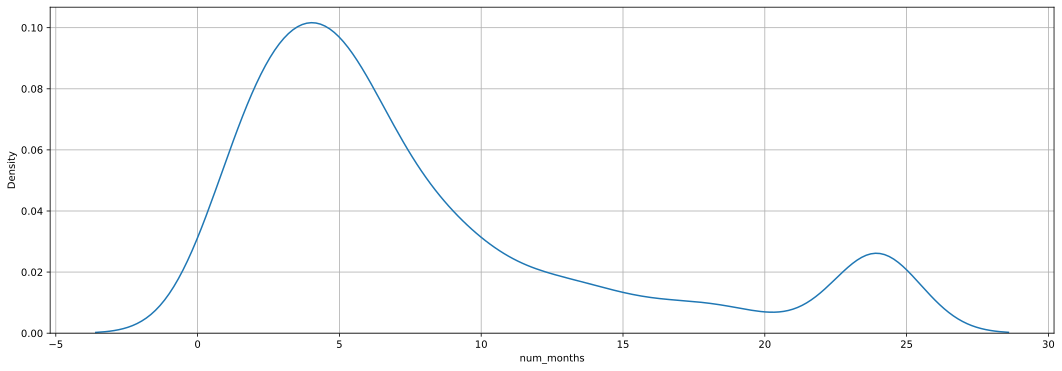

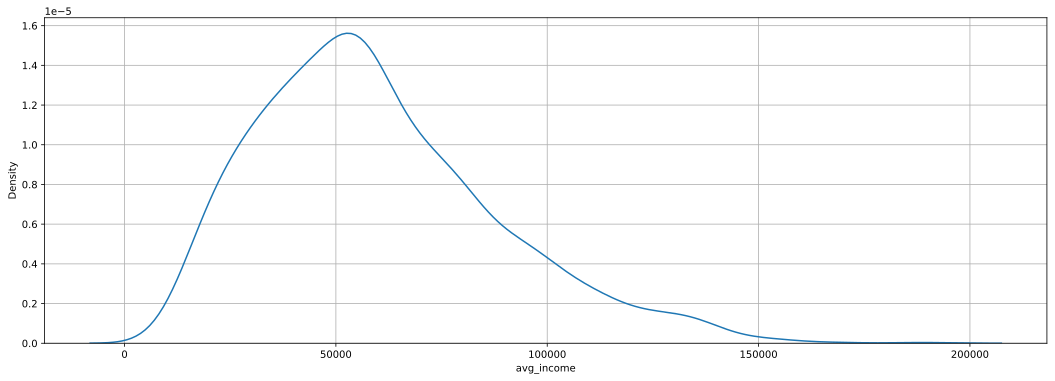

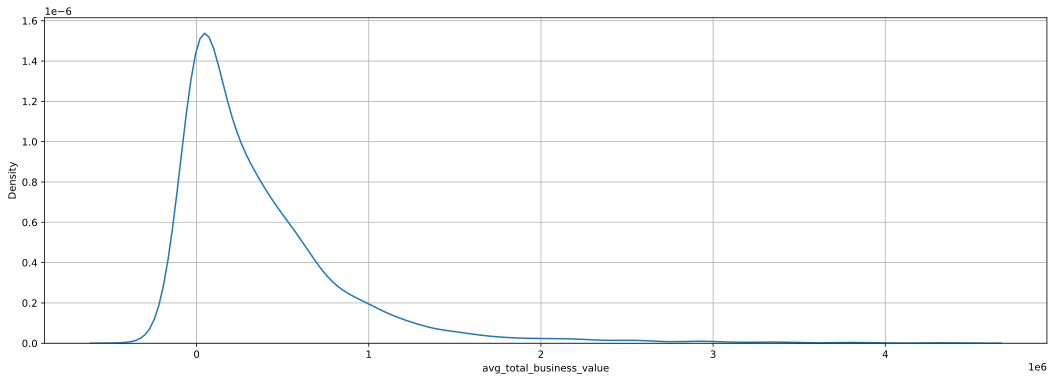

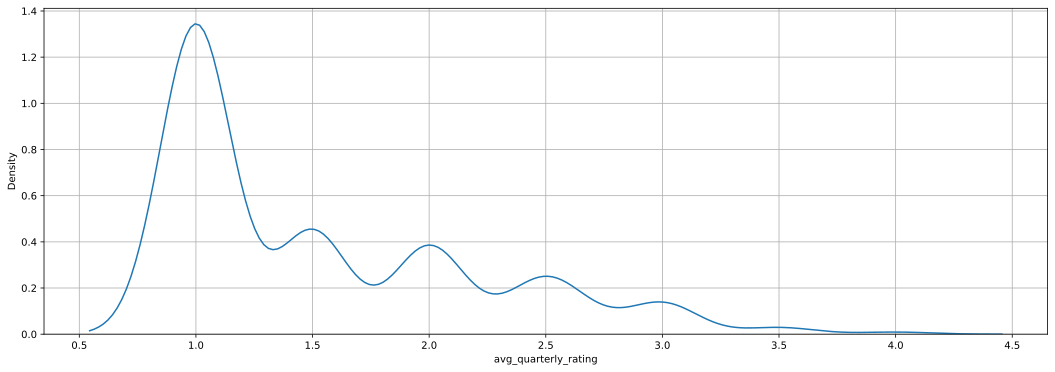

In [198]:
for col in ['num_months', 'avg_income', 'avg_total_business_value', 'avg_quarterly_rating']:
    display_kde_plot(X_train, col)

### Performing outlier handling:

In [199]:
for col in ['num_months', 'avg_income', 'avg_total_business_value', 'avg_quarterly_rating']:
    q1 = np.percentile(X_train[col], 25)
    q3 = np.percentile(X_train[col], 75)
    min_clip_value = q1-1.5*(q3-q1)
    max_clip_value = q3+1.5*(q3-q1)
    X_train[col] = np.clip(X_train[col], min_clip_value, max_clip_value)
    X_cv[col] = np.clip(X_cv[col], min_clip_value, max_clip_value)
    X_test[col] = np.clip(X_test[col], min_clip_value, max_clip_value)

### After outlier handling:

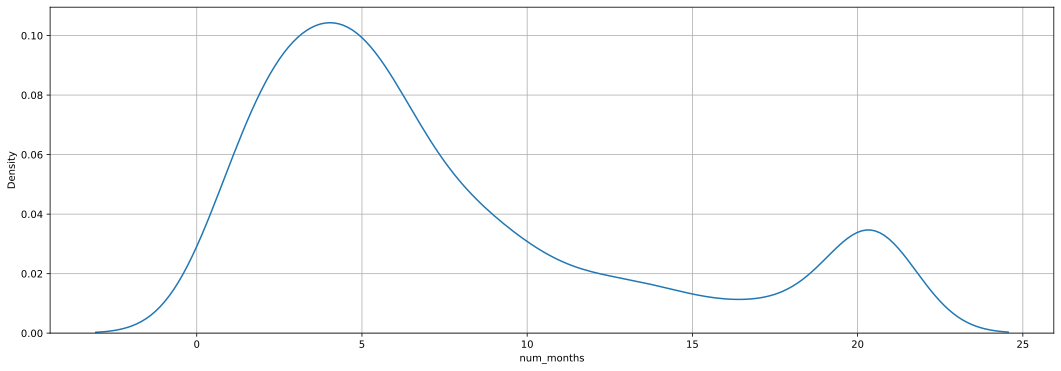

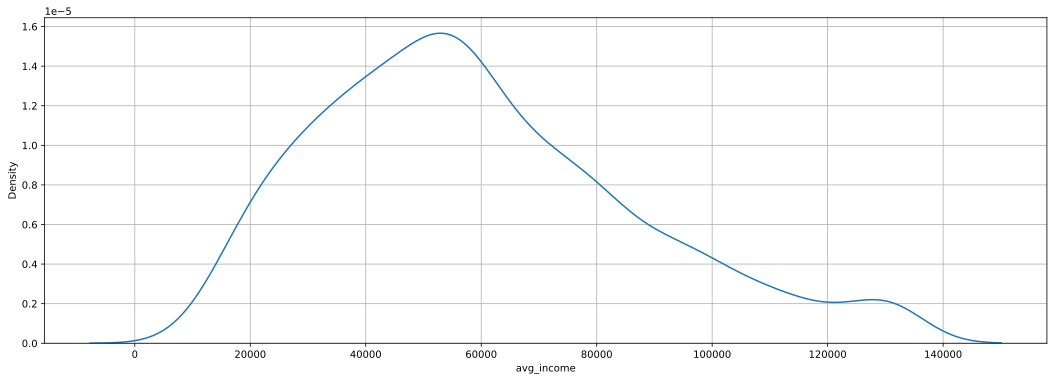

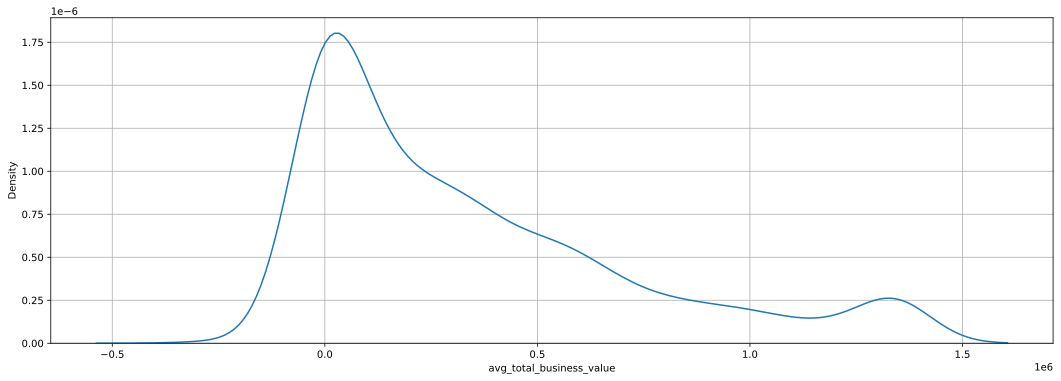

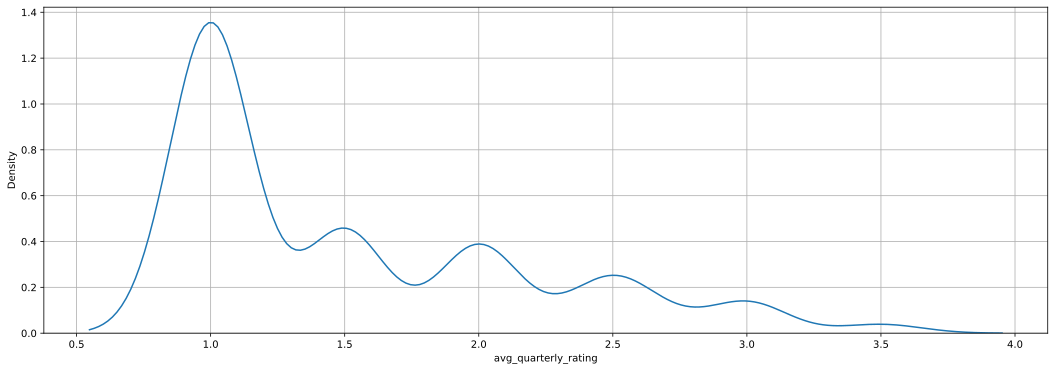

In [200]:
for col in ['num_months', 'avg_income', 'avg_total_business_value', 'avg_quarterly_rating']:
    display_kde_plot(X_train, col)

## Data Preprocessing:
#### Feature Engineering:

#### In this BCS Dataset Standardization is not required since we're building tree based models but for categorical features we will perform One Hot Encoding (OHE)

### One Hot Encoding:

In [201]:
cate_cols = ['City', 'DOJ_Year', 'DOJ_Month', 'is_promoted']

In [202]:
ohe = OneHotEncoder()
ohe.fit(X_train[cate_cols])
feature_names = ohe.get_feature_names_out(cate_cols)

train_encoded = ohe.transform(X_train[cate_cols]).toarray()
train_encoded = pd.DataFrame(train_encoded, columns=feature_names).astype(int)
X_train_encoded = pd.concat([X_train.reset_index(drop=True), train_encoded], axis=1)
X_train_encoded.drop(cate_cols, axis=1, inplace=True)

cv_encoded = ohe.transform(X_cv[cate_cols]).toarray()
cv_encoded = pd.DataFrame(cv_encoded,columns=feature_names).astype(int)
X_cv_encoded = pd.concat([X_cv.reset_index(drop=True), cv_encoded], axis=1)
X_cv_encoded.drop(cate_cols, axis=1, inplace=True)

test_encoded = ohe.transform(X_test[cate_cols]).toarray()
test_encoded = pd.DataFrame(test_encoded, columns=feature_names).astype(int)
X_test_encoded = pd.concat([X_test.reset_index(drop=True), test_encoded], axis=1)
X_test_encoded.drop(cate_cols, axis=1, inplace=True)

In [203]:
print(X_train_encoded.shape)
print(X_cv_encoded.shape)
print(X_test_encoded.shape)

(1719, 61)
(304, 61)
(358, 61)


## Model Building:

### Evaluation Metric:

- Finding out drivers who are more likely to be churned is more important as compared to finding drivers who might not be churned, so in this case, a particular class is more important than the other (class 1: churned) and hence we can choose F1 Score as the right metric which optimizes both Precision and Recall for the "Churned" class

### Helper Functions:

In [204]:
def plot_roc_curve_and_display_auc_roc_score(y_true, y_prob, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.title(f'{dataset_name} ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.show()
    print(f"{dataset_name} AUC ROC Score = {roc_auc_score(y_true, y_prob).round(3)}")

In [205]:
def print_classification_report(y_true, y_pred, target_names = ['Retained', 'Churned']):
    print(
        classification_report(
            y_true, y_pred,
            target_names=target_names
        )
    )

## Baseline Model : Decision Tree:

In [206]:
parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 7, 9, 11],
    'class_weight' : [None, 'balanced'],
    'max_features' : ['sqrt', None]
}

dt = DecisionTreeClassifier()
clf = GridSearchCV(
    estimator = dt,
    param_grid = parameters,
    scoring = 'f1'
)

clf.fit(X_train_encoded, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9, 11],
                         'max_features': ['sqrt', None]},
             scoring='f1')

In [207]:
best_est = clf.best_estimator_
clf.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None}

### Predictions:

In [208]:
y_train_pred = best_est.predict(X_train_encoded)
y_cv_pred = best_est.predict(X_cv_encoded)
y_test_pred = best_est.predict(X_test_encoded)

y_train_pred_proba = best_est.predict_proba(X_train_encoded)[:, 1]
y_cv_pred_proba = best_est.predict_proba(X_cv_encoded)[:, 1]
y_test_pred_proba = best_est.predict_proba(X_test_encoded)[:, 1]

### F1 Score:

In [209]:
print(f'Train F1 Score = {f1_score(y_train, y_train_pred).round(3)}')
print(f'CV F1 Score = {f1_score(y_cv, y_cv_pred).round(3)}')
print(f'Test F1 Score = {f1_score(y_test, y_test_pred).round(3)}')

Train F1 Score = 0.933
CV F1 Score = 0.91
Test F1 Score = 0.891


### AUC-ROC Score:

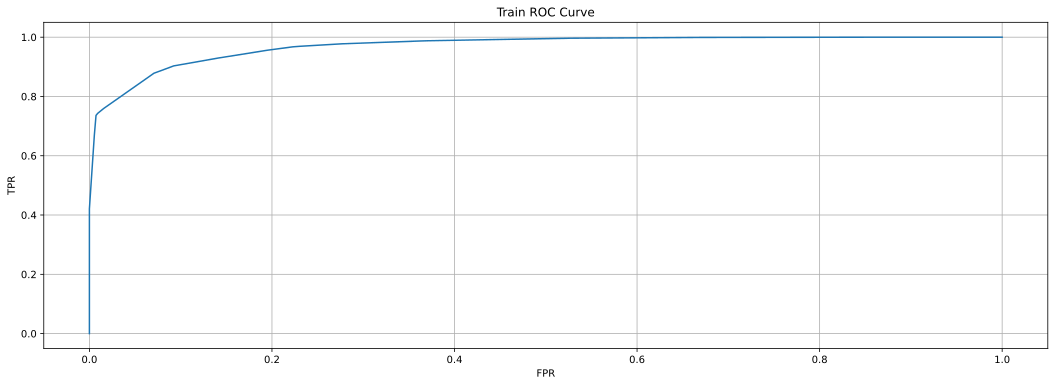

Train AUC ROC Score = 0.97


In [210]:
plot_roc_curve_and_display_auc_roc_score(y_train, y_train_pred_proba, 'Train')

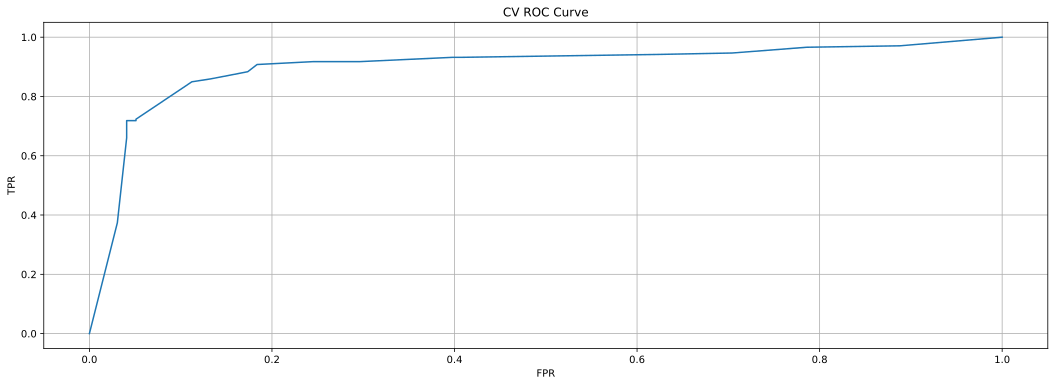

CV AUC ROC Score = 0.901


In [211]:
plot_roc_curve_and_display_auc_roc_score(y_cv, y_cv_pred_proba, 'CV')

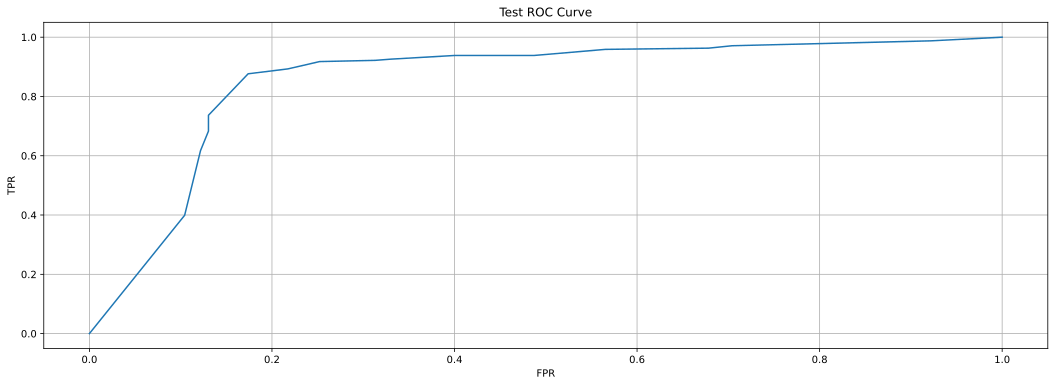

Test AUC ROC Score = 0.858


In [212]:
plot_roc_curve_and_display_auc_roc_score(y_test, y_test_pred_proba, 'Test')

### Classification Report:

In [213]:
print_classification_report(y_train, y_train_pred)

              precision    recall  f1-score   support

    Retained       0.90      0.81      0.85       552
     Churned       0.91      0.96      0.93      1167

    accuracy                           0.91      1719
   macro avg       0.90      0.88      0.89      1719
weighted avg       0.91      0.91      0.91      1719



In [214]:
print_classification_report(y_cv, y_cv_pred)

              precision    recall  f1-score   support

    Retained       0.81      0.82      0.81        98
     Churned       0.91      0.91      0.91       206

    accuracy                           0.88       304
   macro avg       0.86      0.86      0.86       304
weighted avg       0.88      0.88      0.88       304



In [215]:
print_classification_report(y_test, y_test_pred)

              precision    recall  f1-score   support

    Retained       0.81      0.69      0.74       115
     Churned       0.86      0.92      0.89       243

    accuracy                           0.85       358
   macro avg       0.83      0.80      0.82       358
weighted avg       0.84      0.85      0.84       358



#### Baseline model is giving a F1 Score of 0.89 on the test set which is quite good, but Ensemble models are significantly stronger than DT, so these should give better score.

## Bagging (RandomForest Classifier):

In [216]:
parameters = {
    'n_estimators' : [100, 200, 300, 400],
    'max_depth' : [7, 9, 11, 13],
    'max_samples' : [0.25, 0.5, 0.75, 1],
    'max_features' : [0.25, 0.5, 0.75, 'sqrt', None],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf = GridSearchCV(
    estimator = rf,
    param_grid = parameters,
    scoring = 'f1',
    n_jobs=-1,
    cv=3,
    verbose=1
)

clf.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=21),
             n_jobs=-1,
             param_grid={'max_depth': [7, 9, 11, 13],
                         'max_features': [0.25, 0.5, 0.75, 'sqrt', None],
                         'max_samples': [0.25, 0.5, 0.75, 1],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='f1', verbose=1)

In [217]:
best_est = clf.best_estimator_
clf.best_params_

{'max_depth': 11,
 'max_features': 0.5,
 'max_samples': 0.75,
 'n_estimators': 100}

### Predictions:

In [218]:
y_train_pred = best_est.predict(X_train_encoded)
y_cv_pred = best_est.predict(X_cv_encoded)
y_test_pred = best_est.predict(X_test_encoded)

y_train_pred_proba = best_est.predict_proba(X_train_encoded)[:, 1]
y_cv_pred_proba = best_est.predict_proba(X_cv_encoded)[:, 1]
y_test_pred_proba = best_est.predict_proba(X_test_encoded)[:, 1]

### F1 Score:

In [219]:
print(f'Train F1 Score = {f1_score(y_train, y_train_pred).round(3)}')
print(f'CV F1 Score = {f1_score(y_cv, y_cv_pred).round(3)}')
print(f'Test F1 Score = {f1_score(y_test, y_test_pred).round(3)}')

Train F1 Score = 0.979
CV F1 Score = 0.916
Test F1 Score = 0.928


### AUC-ROC Score:

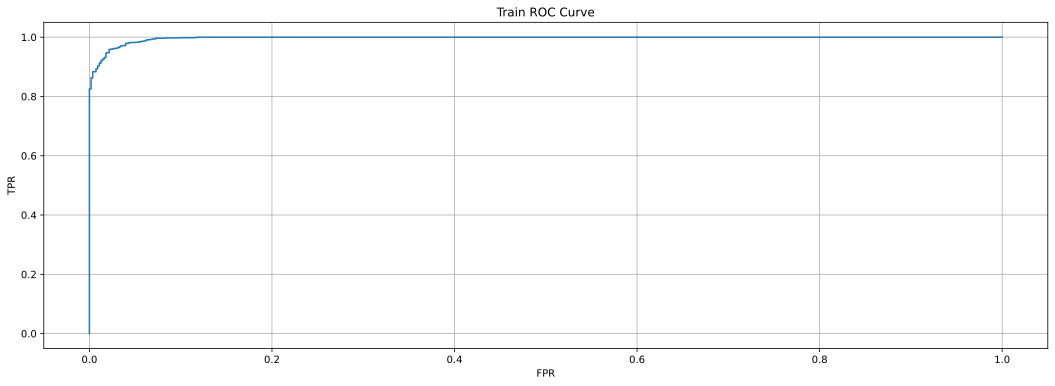

Train AUC ROC Score = 0.997


In [220]:
plot_roc_curve_and_display_auc_roc_score(y_train, y_train_pred_proba, 'Train')

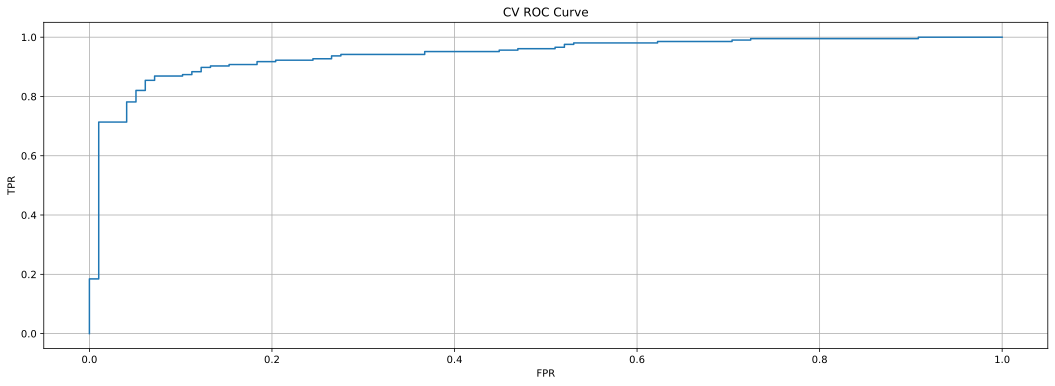

CV AUC ROC Score = 0.942


In [221]:
plot_roc_curve_and_display_auc_roc_score(y_cv, y_cv_pred_proba, 'CV')

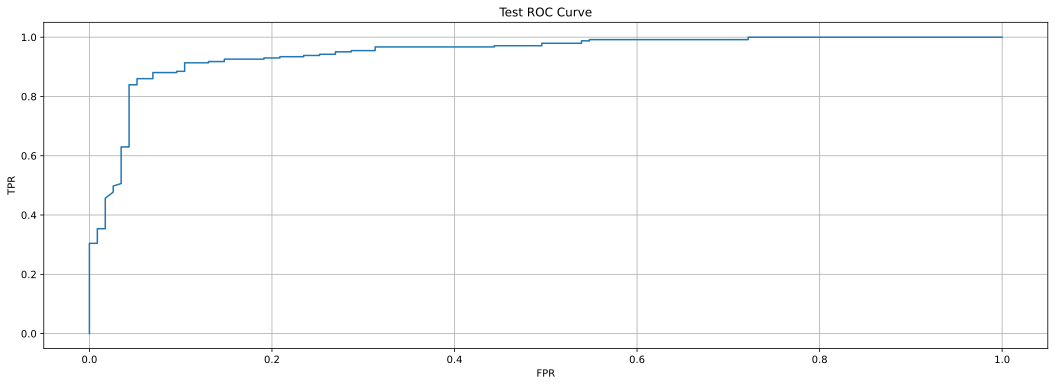

Test AUC ROC Score = 0.946


In [222]:
plot_roc_curve_and_display_auc_roc_score(y_test, y_test_pred_proba, 'Test')

### Classification Report:

In [223]:
print_classification_report(y_train, y_train_pred)

              precision    recall  f1-score   support

    Retained       0.97      0.94      0.95       552
     Churned       0.97      0.99      0.98      1167

    accuracy                           0.97      1719
   macro avg       0.97      0.96      0.97      1719
weighted avg       0.97      0.97      0.97      1719



In [224]:
print_classification_report(y_cv, y_cv_pred)

              precision    recall  f1-score   support

    Retained       0.81      0.86      0.83        98
     Churned       0.93      0.90      0.92       206

    accuracy                           0.89       304
   macro avg       0.87      0.88      0.87       304
weighted avg       0.89      0.89      0.89       304



In [225]:
print_classification_report(y_test, y_test_pred)

              precision    recall  f1-score   support

    Retained       0.84      0.85      0.85       115
     Churned       0.93      0.93      0.93       243

    accuracy                           0.90       358
   macro avg       0.89      0.89      0.89       358
weighted avg       0.90      0.90      0.90       358



#### RandomForest Model Test Score (0.93) is better than DT model but it's slightly overfitting

## Boosting (LightGBM):

In [226]:
parameters = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'max_depth' : [1,3,5,7],
    'learning_rate' : [0.025, 0.05, 0.1, 0.2],
    'subsample' : [0.2, 0.4, 0.6, 0.8, 1],
    'colsample_bytree' : [0.2, 0.4, 0.6, 0.8, 1],
}

lgbm_model = lgbm.LGBMClassifier(random_state=42, n_jobs=-1)
clf = GridSearchCV(
    estimator = lgbm_model,
    param_grid= parameters,
    scoring = 'f1',
    n_jobs=-1,
    cv=3,
    verbose=2
)

clf.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1],
                         'learning_rate': [0.025, 0.05, 0.1, 0.2],
                         'max_depth': [1, 3, 5, 7],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'subsample': [0.2, 0.4, 0.6, 0.8, 1]},
             scoring='f1', verbose=2)

In [227]:
best_est = clf.best_estimator_
clf.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.025,
 'max_depth': 7,
 'n_estimators': 400,
 'subsample': 0.2}

### Predictions:

In [228]:
y_train_pred = best_est.predict(X_train_encoded)
y_cv_pred = best_est.predict(X_cv_encoded)
y_test_pred = best_est.predict(X_test_encoded)

y_train_pred_proba = best_est.predict_proba(X_train_encoded)[:, 1]
y_cv_pred_proba = best_est.predict_proba(X_cv_encoded)[:, 1]
y_test_pred_proba = best_est.predict_proba(X_test_encoded)[:, 1]

### F1 Score:

In [229]:
print(f'Train F1 Score = {f1_score(y_train, y_train_pred).round(3)}')
print(f'CV F1 Score = {f1_score(y_cv, y_cv_pred).round(3)}')
print(f'Test F1 Score = {f1_score(y_test, y_test_pred).round(3)}')

Train F1 Score = 0.968
CV F1 Score = 0.917
Test F1 Score = 0.913


### AUC-ROC Score:

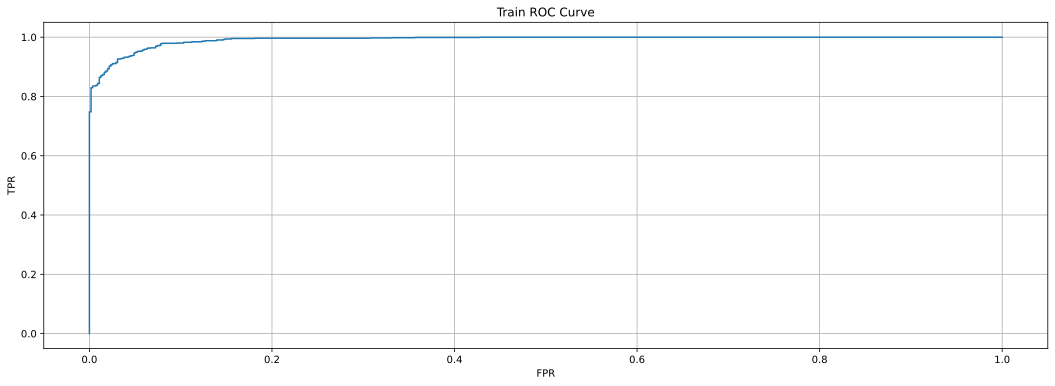

Train AUC ROC Score = 0.992


In [230]:
plot_roc_curve_and_display_auc_roc_score(y_train, y_train_pred_proba, 'Train')

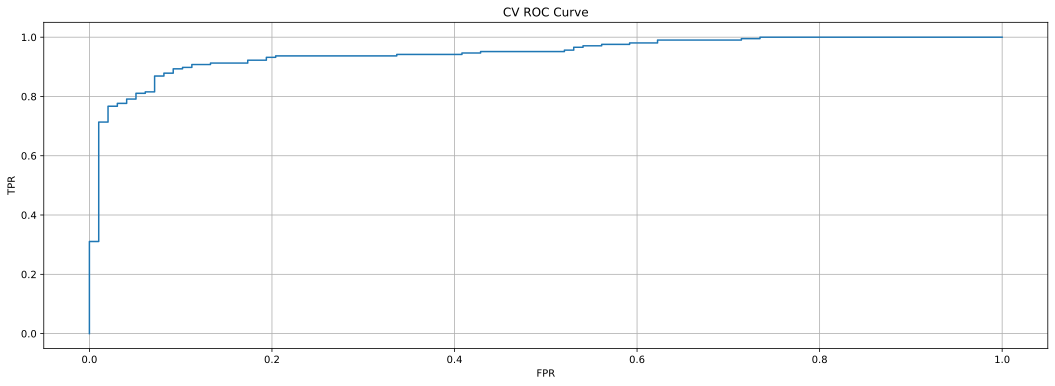

CV AUC ROC Score = 0.945


In [231]:
plot_roc_curve_and_display_auc_roc_score(y_cv, y_cv_pred_proba, 'CV')

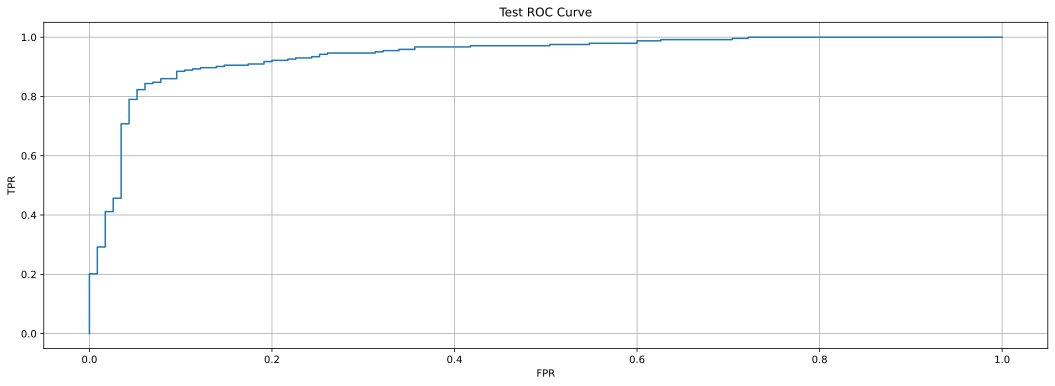

Test AUC ROC Score = 0.939


In [232]:
plot_roc_curve_and_display_auc_roc_score(y_test, y_test_pred_proba, 'Test')

#### The AUC is pretty high for all the ROC curves but since the original data is imbalanced, AUC-ROC is not a right metric

### Classification Report:

In [233]:
print_classification_report(y_train, y_train_pred)

              precision    recall  f1-score   support

    Retained       0.94      0.93      0.93       552
     Churned       0.97      0.97      0.97      1167

    accuracy                           0.96      1719
   macro avg       0.95      0.95      0.95      1719
weighted avg       0.96      0.96      0.96      1719



In [234]:
print_classification_report(y_cv, y_cv_pred)

              precision    recall  f1-score   support

    Retained       0.82      0.84      0.83        98
     Churned       0.92      0.91      0.92       206

    accuracy                           0.89       304
   macro avg       0.87      0.87      0.87       304
weighted avg       0.89      0.89      0.89       304



In [235]:
print_classification_report(y_test, y_test_pred)

              precision    recall  f1-score   support

    Retained       0.84      0.77      0.81       115
     Churned       0.90      0.93      0.91       243

    accuracy                           0.88       358
   macro avg       0.87      0.85      0.86       358
weighted avg       0.88      0.88      0.88       358



#### GBDT Model Test Score (0.91) is better than DT model but worse than RF model but it's not overfitting, so given a choice between the three, GBDT is the best.

### Confusion Matrix:

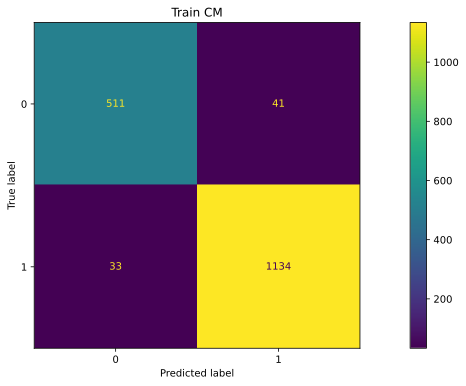

In [236]:
# Retained = 0
# Churned = 1

conf_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Train CM")
plt.show()

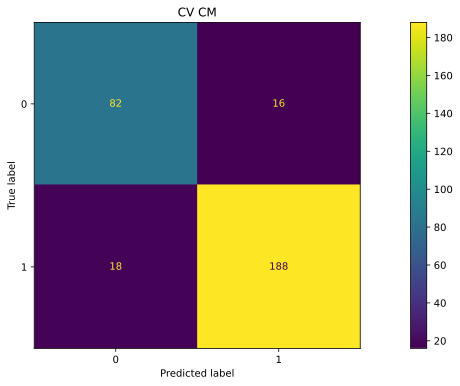

In [237]:
# Retained = 0
# Churned = 1

conf_matrix = confusion_matrix(y_cv, y_cv_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("CV CM")
plt.show()

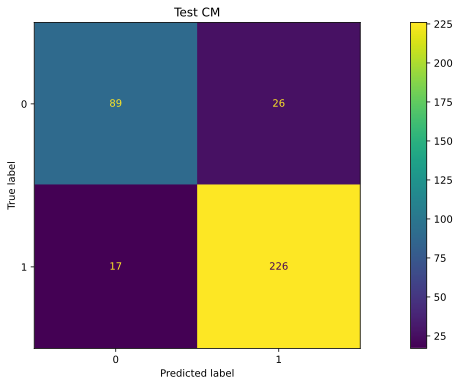

In [238]:
# Retained = 0
# Churned = 1

conf_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Test CM")
plt.show()

## Treating class imbalance:
#### Let's train the best model we got using class_weights='balanced' parameter and check the performance

In [239]:
lgbm_model = lgbm.LGBMClassifier(
    colsample_bytree = 0.4,
    learning_rate = 0.025,
    max_depth = 3,
    n_estimators = 300,
    subsample = 0.2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lgbm_model.fit(X_train_encoded, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.4,
               learning_rate=0.025, max_depth=3, n_estimators=300,
               random_state=42, subsample=0.2)

### Predictions:

In [240]:
y_train_pred = lgbm_model.predict(X_train_encoded)
y_cv_pred = lgbm_model.predict(X_cv_encoded)
y_test_pred = lgbm_model.predict(X_test_encoded)

y_train_pred_proba = lgbm_model.predict_proba(X_train_encoded)[:, 1]
y_cv_pred_proba = lgbm_model.predict_proba(X_cv_encoded)[:, 1]
y_test_pred_proba = lgbm_model.predict_proba(X_test_encoded)[:, 1]

### F1 Score:

In [241]:
print(f'Train F1 Score = {f1_score(y_train, y_train_pred).round(3)}')
print(f'CV F1 Score = {f1_score(y_cv, y_cv_pred).round(3)}')
print(f'Test F1 Score = {f1_score(y_test, y_test_pred).round(3)}')

Train F1 Score = 0.905
CV F1 Score = 0.899
Test F1 Score = 0.915


### AUC-ROC Score:

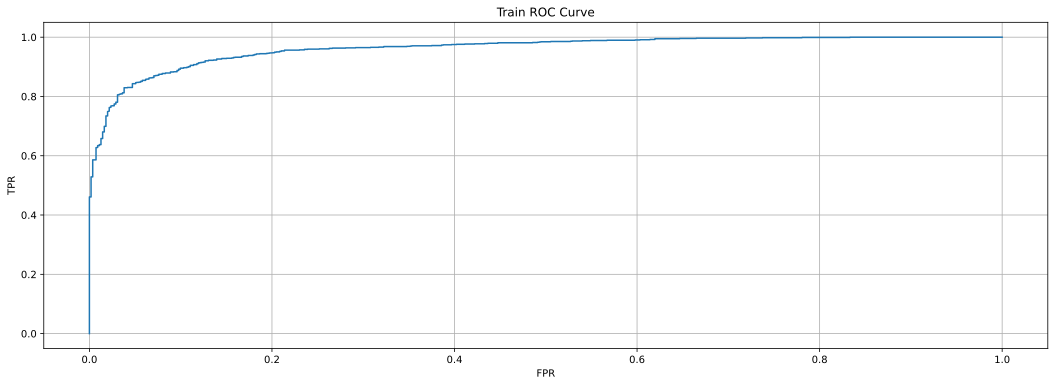

Train AUC ROC Score = 0.962


In [242]:
plot_roc_curve_and_display_auc_roc_score(y_train, y_train_pred_proba, 'Train')

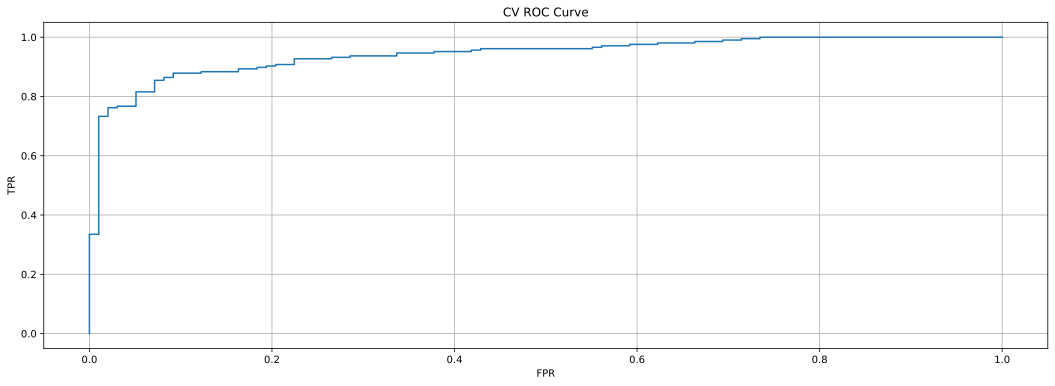

CV AUC ROC Score = 0.942


In [243]:
plot_roc_curve_and_display_auc_roc_score(y_cv, y_cv_pred_proba, 'CV')

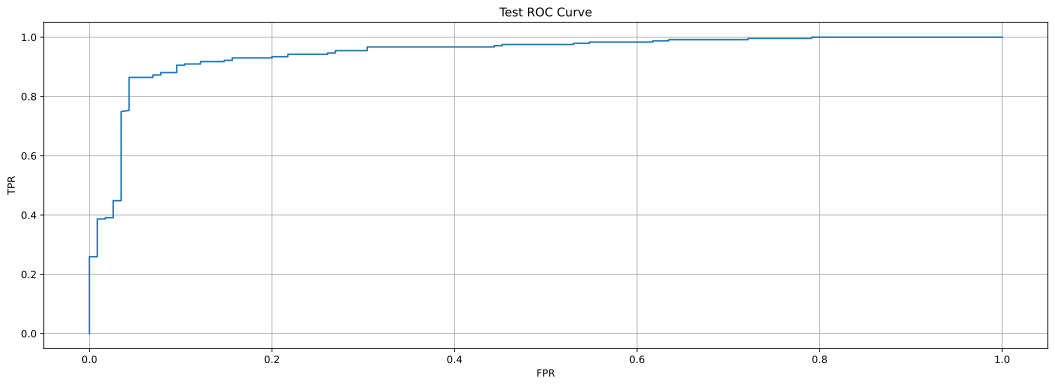

Test AUC ROC Score = 0.946


In [244]:
plot_roc_curve_and_display_auc_roc_score(y_test, y_test_pred_proba, 'Test')

### Classification Report:

In [245]:
print_classification_report(y_train, y_train_pred)

              precision    recall  f1-score   support

    Retained       0.75      0.94      0.83       552
     Churned       0.97      0.85      0.90      1167

    accuracy                           0.88      1719
   macro avg       0.86      0.90      0.87      1719
weighted avg       0.90      0.88      0.88      1719



In [246]:
print_classification_report(y_train, y_train_pred)

              precision    recall  f1-score   support

    Retained       0.75      0.94      0.83       552
     Churned       0.97      0.85      0.90      1167

    accuracy                           0.88      1719
   macro avg       0.86      0.90      0.87      1719
weighted avg       0.90      0.88      0.88      1719



In [247]:
print_classification_report(y_test, y_test_pred)

              precision    recall  f1-score   support

    Retained       0.77      0.95      0.85       115
     Churned       0.97      0.86      0.92       243

    accuracy                           0.89       358
   macro avg       0.87      0.91      0.88       358
weighted avg       0.91      0.89      0.89       358



#### After balancing, recall on the "retained" class has improved significantly and performance on "churned" class has also slightly increased, so it's better if we choose the model with class balancing

## Finding Best Threshold for classification:

In [248]:
predicted_proba_train = best_est.predict_proba(X_train_encoded)
predicted_proba_cv = best_est.predict_proba(X_cv_encoded)
train_f1_scores = []
cv_f1_scores = []
thresholds = np.arange(0.05, 1, 0.025)

for threshold in thresholds:
    train_preds = (predicted_proba_train[:,1] >= threshold).astype('int')
    cv_preds = (predicted_proba_cv[:,1] >= threshold).astype('int')
    trainF1Score = f1_score(y_train, train_preds)
    cvF1Score = f1_score(y_cv, cv_preds)
    train_f1_scores.append(trainF1Score)
    cv_f1_scores.append(cvF1Score)

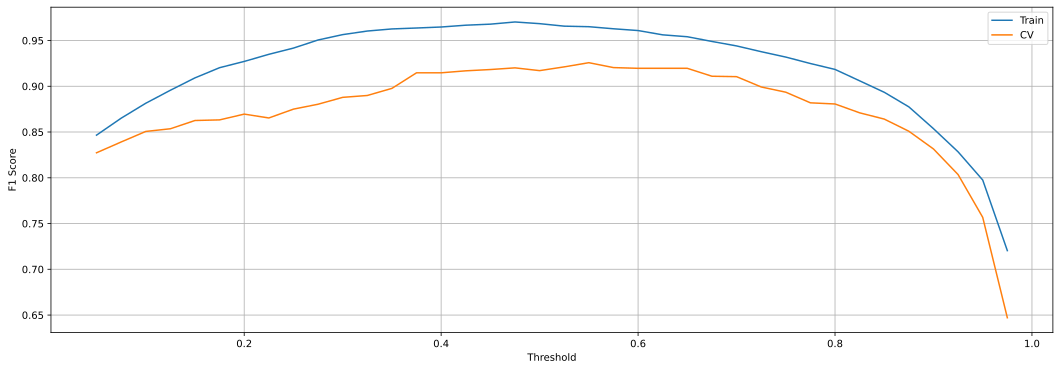

In [250]:
plt.rcParams["figure.figsize"] = (18,6)
plt.plot(thresholds, train_f1_scores, label='Train')
plt.plot(thresholds, cv_f1_scores, label='CV')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid()
plt.legend()
plt.show()

In [251]:
best_threshold_idx = np.argmax(cv_f1_scores)
best_threshold = thresholds[best_threshold_idx]

predicted_proba_test = best_est.predict_proba(X_test_encoded)
test_preds = (predicted_proba_test[:,1] >= best_threshold).astype('int')

print(f"Best threshold = {best_threshold.round(3)} \nTrain F1 Score = {train_f1_scores[best_threshold_idx].round(3)} \nCV F1 Score = {cv_f1_scores[best_threshold_idx].round(3)} \nTest F1 Score = {f1_score(y_test, test_preds).round(3)}")

Best threshold = 0.55 
Train F1 Score = 0.965 
CV F1 Score = 0.926 
Test F1 Score = 0.911


#### The best model has a F1 Score of 0.91 which is decent enough and it's also not overfitting

## Saving the best model:

In [252]:
joblib.dump(best_est, 'best_model.joblib')

['best_model.joblib']

## Feature importance:

In [253]:
def plot_top_feature_importances(model):
    plt.rcParams["figure.figsize"] = (18,8)
    
    fnames = list(model.feature_name_)
    fimps = list(model.feature_importances_)
    fname_imp_dict = dict(zip(fnames, fimps))
    fname_imp_dict = dict(sorted(fname_imp_dict.items(), key=lambda x: x[1], reverse=True))
    df_fname_dict = pd.DataFrame(fname_imp_dict.items(), columns=['fname', 'fimp'])
    df_fname_dict.loc[df_fname_dict.fname.str.startswith('DOJ_Year'), 'fname'] = 'DOJ_Year'
    df_fname_dict.loc[df_fname_dict.fname.str.startswith('DOJ_Month'), 'fname'] = 'DOJ_Month'
    df_fname_dict.loc[df_fname_dict.fname.str.startswith('City'), 'fname'] = 'City'
    df_fname_dict.loc[df_fname_dict.fname.str.startswith('is_promoted'), 'fname'] = 'is_promoted'
    df_fname_dict = df_fname_dict.groupby('fname').agg({'fimp' : 'sum'}).reset_index()
    df_fname_dict.sort_values(by='fimp', ascending=False, inplace=True)
    f_names = list(df_fname_dict['fname'].values)
    f_values = list(df_fname_dict['fimp'].values)
    
    plt.barh(f_names, f_values)
    plt.gca().invert_yaxis()
    plt.title("Feature importance plot")
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.show()

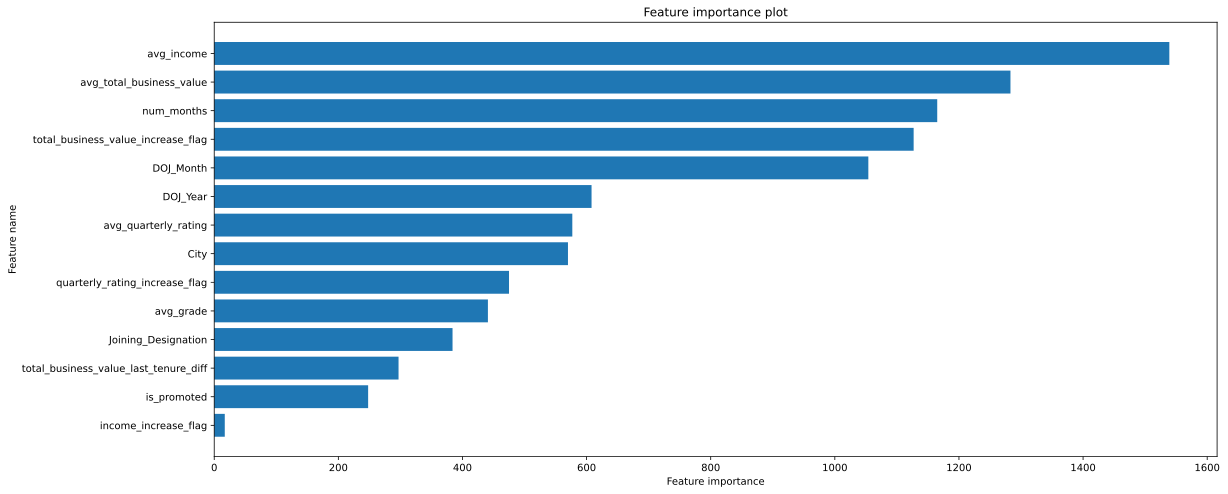

In [254]:
plot_top_feature_importances(best_est)

#### The top 5 most important features for predicting is_churned are: avg_income , avg_total_business_value , num_months , total_business_value_increase_flag , DOJ_Month

## Error Analysis:

### Recreating the original DataFrame:

In [255]:
X_total = pd.concat([X_train_encoded, X_cv_encoded, X_test_encoded]).reset_index(drop=True)

y_total = pd.concat([y_train, y_cv, y_test]).reset_index(drop=True)
y_pred = best_est.predict(X_total)
y_pred_proba = best_est.predict_proba(X_total)[:, 1]
df_total = X_total.copy()
df_total['is_churned_true'] = y_total
df_total['is_churned_pred'] = y_pred
df_total['is_churned_pred_proba'] = y_pred_proba

df_orig_cols = pd.DataFrame(
    ohe.inverse_transform(
        df_total.iloc[:, 10:61]
    ),
    columns=['City', 'DOJ_Year', 'DOJ_Month', 'is_promoted']
)

df_orig = pd.concat(
    [
        df_total.iloc[:, :10],
        df_orig_cols,
        df_total.iloc[:, 61:]
    ],
    axis=1
)

In [256]:
df_orig.head()

,num_months,Joining_Designation,avg_income,income_increase_flag,avg_grade,avg_total_business_value,total_business_value_increase_flag,total_business_value_last_tenure_diff,avg_quarterly_rating,quarterly_rating_increase_flag,City,DOJ_Year,DOJ_Month,is_promoted,is_churned_true,is_churned_pred,is_churned_pred_proba
0,6.0,3,92079.0,0.0,3.0,7.632000e+04,1.000000,1,1.0,0.0,C8,2020,June,0,0,0,0.456671
1,7.0,3,131472.0,0.0,3.0,2.810500e+05,0.333333,1,1.5,1.0,C7,2020,June,0,0,0,0.054709
2,20.5,1,129596.5,1.0,3.5,1.345574e+06,-0.043478,1,3.0,-1.0,C9,2018,March,1,0,0,0.008234
3,6.0,1,21792.0,0.0,1.0,1.123900e+05,1.000000,1,1.0,0.0,C25,2020,June,0,1,1,0.881170
4,5.0,3,82822.0,0.0,3.0,4.750000e+05,1.000000,1,1.5,1.0,C17,2020,February,0,0,0,0.205839


In [257]:
df_orig.tail()

,num_months,Joining_Designation,avg_income,income_increase_flag,avg_grade,avg_total_business_value,total_business_value_increase_flag,total_business_value_last_tenure_diff,avg_quarterly_rating,quarterly_rating_increase_flag,City,DOJ_Year,DOJ_Month,is_promoted,is_churned_true,is_churned_pred,is_churned_pred_proba
2376,1.0,1,45278.0,0.0,1.0,0.000000,0.000000,0,1.000000,0.0,C9,2018,August,0,1,1,0.997303
2377,3.0,2,21412.0,0.0,2.0,0.000000,0.000000,0,1.000000,0.0,C20,2020,September,0,0,1,0.576973
2378,14.0,1,23094.0,0.0,1.0,761058.461538,0.500000,1,2.666667,1.0,C27,2019,January,0,0,0,0.219034
2379,11.0,1,30860.0,0.0,2.0,360536.000000,0.111111,-1,2.000000,0.0,C29,2018,May,1,1,1,0.995829
2380,3.0,2,55344.0,0.0,2.0,0.000000,0.000000,0,1.000000,0.0,C24,2020,June,0,1,1,0.889341


### Analyzing the Errors:

In [258]:
error_df = df_orig.loc[df_orig['is_churned_pred']!=df_orig['is_churned_true']]

def get_per_point_logloss(row):
    y = row['is_churned_true']
    p = row['is_churned_pred_proba']
    if y:
        return -np.log(p)
    return -np.log(1-p)

error_df['log_loss'] = error_df.apply(get_per_point_logloss, axis=1)
error_df.sort_values(by=['log_loss'], ascending=False, inplace=True)

In [259]:
print(f"False Positive % : {round(error_df[(error_df['is_churned_true']==0)&(error_df['is_churned_pred']==1)].shape[0]/error_df.shape[0]*100, 3)}")
print(f"False Negative % : {round(error_df[(error_df['is_churned_true']==1)&(error_df['is_churned_pred']==0)].shape[0]/error_df.shape[0]*100, 3)}")

False Positive % : 54.967
False Negative % : 45.033


In [261]:
error_df.head(10)

,num_months,Joining_Designation,avg_income,income_increase_flag,avg_grade,avg_total_business_value,total_business_value_increase_flag,total_business_value_last_tenure_diff,avg_quarterly_rating,quarterly_rating_increase_flag,City,DOJ_Year,DOJ_Month,is_promoted,is_churned_true,is_churned_pred,is_churned_pred_proba,log_loss
2330,15.0,1,43969.0,0.0,1.0,4.200400e+05,-0.090909,-1,2.000000,-1.0,C17,2018,September,0,0,1,0.996518,5.660289
2296,9.0,2,112424.0,0.0,4.0,7.912067e+05,-0.250000,-1,1.500000,-1.0,C12,2014,January,1,0,1,0.994090,5.131105
2003,5.0,3,67685.0,0.0,3.0,0.000000e+00,0.000000,0,1.000000,0.0,C27,2019,December,0,0,1,0.992388,4.878057
2340,5.0,2,59481.0,0.0,2.0,0.000000e+00,0.000000,0,1.000000,0.0,C5,2019,November,0,0,1,0.986860,4.332064
2036,4.0,1,24291.0,0.0,1.0,0.000000e+00,0.000000,0,1.000000,0.0,C5,2019,October,0,0,1,0.982726,4.058536
2139,20.5,1,56611.0,0.0,2.0,6.102084e+05,0.222222,1,2.500000,-1.0,C10,2015,July,1,1,0,0.058835,2.833019
2160,8.0,3,61912.0,0.0,3.0,1.206325e+06,0.200000,-1,2.666667,0.0,C29,2020,January,0,1,0,0.066335,2.713038
2237,3.0,2,29719.0,0.0,2.0,0.000000e+00,0.000000,0,1.000000,0.0,C21,2020,February,0,0,1,0.912585,2.437092
1879,5.0,3,102175.0,0.0,3.0,5.119100e+05,1.000000,1,1.500000,1.0,C21,2020,August,0,1,0,0.096997,2.333077
2198,20.5,1,109652.0,0.0,3.0,5.610273e+05,0.047619,-1,2.000000,0.0,C6,2015,December,1,1,0,0.097221,2.330771


#### Key Observations:
1. The datapoints with the highest log loss are FP, many of these have avg TBV as 0, hence the model inferred them as being churned, this could be an error in collecting data so Ola should be more cautious while collecting data
2. Most of these have joined the company in year 2019 which has one of the highest churn rate and hence model is classifying these as "churned"
3. Most of these have very low average quarterly rating hence model is thinking of these as "churned" drivers

## Insights and Recommendations:

## Insights:

#### Exploratory Data Analysis (EDA):
    1. Year of joining of driver is an important factor in determining the probability of being churned, year 2014 and 2020 have low churn rate where as 2018 and 2019 have very high churn rate
    2. Average income of churned drivers is slighly less as compared to non churned drivers
    3. The churn rate is significantly low when the driver's income has increased over his/her tenure at OLA
    4. Churned rate is significantly lower when the driver has been promoted during his tenure at OLA
    5. Average total business value is significantly less for churned drivers
    6. As the number of months spent at OLA increases, the probability of driver being churned decreases
    7. Age, gender and education level don't have significant effect on the probability of driver being churned
    8. After training the model, it was found that, Year of joining the company, Month of joining the company, number of months spent at OLA, total average business value generated by the driver and average quarterly rating of the driver are the 5 most important features
    9. The model has a very high precision for churned drivers which means if the model says someone will be churned, he'll definitely be churned while it has high recall for retained drivers which means it's able to correctly remember the actual retained drivers
    10. Driver's city is an important factor in determining the probability of being churned, cities like C13, C17, C2 have higher than average churn rate while cities like C12, C16, C19, C21, C22 have lower than average churn rate
    11. Churn rate generally decreases as we go up the designation (designations 4 and 5 have less datapoints so they can be outliers also)
    12. Churn rate is significantly lower when TBV has increased in the last month as compared to the previous month, this seems an important feature
    13. As average quarterly ratings increases, churn rate decreases
    14. The churn rate is significantly lower when the quarterly rating has increased over the last month
    15. Average income, Average TBV and Average quarterly rating have significant outliers on the higher end

#### Final Model:
    1. Best threshold = 0.55 
    2. Train F1 Score = 0.965 
    3. CV F1 Score = 0.926 
    4. Test F1 Score = 0.911

## Recommendations:

1. If a driver's Total Business Value is constantly decreasing over the months, he's most likely to be churned, OLA should talk to the drivers to find the reason for this decrease in TBV
2. OLA should pay close attention to newly joined drivers as churn rate is highest among them, some incentives can be given to these drivers to retain them, once they spend enough time at OLA, probability of being churned decreases significantly
3. OLA should give regular increments in pay/grade to drivers as the churn rate decreases significantly when drivers receive increase in pay/grade
4. Some cities like C13, C17, C2 have higher than average churn rate, the reason for this should be investigated, it could be because competitive firms are paying higher or probably because there aren't many customers here so that drivers can recover the base cost, after investigating the reasons, proper corrective measures should be taken for their rectification
5. OLA should pay close attention to driver's average quarterly ratings as those with low quarterly ratings tend to churn more, the reason for low ratings can be due to their unprofessional behaviour with customers and since quarterly ratings directly impact incentives and future rides, the drivers churn, so OLA should pay attention in educating the drivers to behave properly with customers and be on time, not cancel the ride unccessarily etc
6. OLA should be pay close attention to drivers joining on designation 1 and 2 as the churn rate is max. among these, the probable reason is low pay at OLA and higher pay at other competitive firms, the pay scale should be corrected for these drivers if it's lower than other competitive firms.